In [1]:
import pycalphad
from pycalphad import Database

In [2]:
import copy
import warnings
from symengine import exp, log, Abs, Add, And, Float, Mul, Piecewise, Pow, S, sin, StrictGreaterThan, Symbol, zoo, oo
from tinydb import where
import pycalphad.variables as v
from pycalphad.core.errors import DofError
from pycalphad.core.constants import MIN_SITE_FRACTION
from pycalphad.core.utils import unpack_components, get_pure_elements, wrap_symbol
import numpy as np
from collections import OrderedDict
from tinydb import where
from pycalphad import Model, variables as v
import itertools

In [3]:
class ModelUNIQUAC(Model):
    
    contributions = [
        ("ref", "reference_energy"),
        ("idmix", "ideal_mixing_energy"),
        #("xsmix", "excess_mixing_energy"),
        ("cmbxmix", "combinatorial_contribution_excess_mixing_energy"),
        #("resxmix", "residual_contribution_excess_mixing_energy"),
    ]
    
    def __init__(self, dbe, comps, phase_name, parameters=None):
        self._dbe = dbe
        self._endmember_reference_model = None
        self.components = set()
        self.constituents = []
        self.phase_name = phase_name.upper()
        phase = dbe.phases[self.phase_name]
        self.site_ratios = list(phase.sublattices)
        active_species = unpack_components(dbe, comps)
        for idx, sublattice in enumerate(phase.constituents):
            subl_comps = set(sublattice).intersection(active_species)
            self.components |= subl_comps

        self.site_ratios = tuple(self.site_ratios)

        # Verify that this phase is still possible to build
        is_pure_VA = set()
        for sublattice in phase.constituents:
            sublattice_comps = set(sublattice).intersection(self.components)
            if len(sublattice_comps) == 0:
                # None of the components in a sublattice are active
                # We cannot build a model of this phase
                raise DofError(
                    '{0}: Sublattice {1} of {2} has no components in {3}' \
                    .format(self.phase_name, sublattice,
                            phase.constituents,
                            self.components))
            is_pure_VA.add(sum(set(map(lambda s : getattr(s, 'number_of_atoms'),sublattice_comps))))
            self.constituents.append(sublattice_comps)
        if sum(is_pure_VA) == 0:
            #The only possible component in a sublattice is vacancy
            #We cannot build a model of this phase
            raise DofError(
                '{0}: Sublattices of {1} contains only VA (VACUUM) constituents' \
                .format(self.phase_name, phase.constituents))
        self.components = sorted(self.components)
        desired_active_pure_elements = [list(x.constituents.keys()) for x in self.components]
        desired_active_pure_elements = [el.upper() for constituents in desired_active_pure_elements
                                        for el in constituents]
        self.pure_elements = sorted(set(desired_active_pure_elements))
        self.nonvacant_elements = [x for x in self.pure_elements if x != 'VA']

        # Convert string symbol names to Symbol objects
        # This makes xreplace work with the symbols dict
        symbols = {Symbol(s): val for s, val in dbe.symbols.items()}

        if parameters is not None:
            self._parameters_arg = parameters
            if isinstance(parameters, dict):
                symbols.update([(wrap_symbol(s), val) for s, val in parameters.items()])
            else:
                # Lists of symbols that should remain symbolic
                for s in parameters:
                    symbols.pop(wrap_symbol(s))
        else:
            self._parameters_arg = None

        self._symbols = {wrap_symbol(key): value for key, value in symbols.items()}

        self.models = OrderedDict()
        self.build_phase(dbe)

        for name, value in self.models.items():
            # XXX: xreplace hack because SymEngine seems to let Symbols slip in somehow
            self.models[name] = self.symbol_replace(value, symbols).xreplace(v.supported_variables_in_databases)

        self.site_fractions = sorted([x for x in self.variables if isinstance(x, v.SiteFraction)], key=str)
        self.state_variables = sorted([x for x in self.variables if not isinstance(x, v.SiteFraction)], key=str)
    @staticmethod


    def __eq__(self, other):
        if self is other:
            return True
        elif type(self) != type(other):
            return False
        else:
            return self.__dict__ == other.__dict__

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(repr(self))

    def moles(self, species, per_formula_unit=False):
        "Number of moles of species or elements."
        species = v.Species(species)
        is_pure_element = (len(species.constituents.keys()) == 1 and
                           list(species.constituents.keys())[0] == species.name)
        result = S.Zero
        normalization = S.Zero
        if is_pure_element:
            element = list(species.constituents.keys())[0]
            for idx, sublattice in enumerate(self.constituents):
                active = set(sublattice).intersection(self.components)
                result += self.site_ratios[idx] * \
                    sum(int(spec.number_of_atoms > 0) * spec.constituents.get(element, 0) * v.SiteFraction(self.phase_name, idx, spec)
                        for spec in active)
                normalization += self.site_ratios[idx] * \
                    sum(spec.number_of_atoms * v.SiteFraction(self.phase_name, idx, spec)
                        for spec in active)
        else:
            for idx, sublattice in enumerate(self.constituents):
                active = set(sublattice).intersection({species})
                if len(active) == 0:
                    continue
                result += self.site_ratios[idx] * sum(v.SiteFraction(self.phase_name, idx, spec) for spec in active)
                normalization += self.site_ratios[idx] * \
                    sum(int(spec.number_of_atoms > 0) * v.SiteFraction(self.phase_name, idx, spec)
                        for spec in active)
        if not per_formula_unit:
            return result / normalization
        else:
            return result

    @property
    def ast(self):
        "Return the full abstract syntax tree of the model."
        return Add(*list(self.models.values()))

    @property
    def variables(self):
        "Return state variables in the model."
        return sorted([x for x in self.ast.free_symbols if isinstance(x, v.StateVariable)], key=str)

    @property
    def degree_of_ordering(self):
        result = S.Zero
        site_ratio_normalization = S.Zero
        # Calculate normalization factor
        for idx, sublattice in enumerate(self.constituents):
            active = set(sublattice).intersection(self.components)
            subl_content = sum(int(spec.number_of_atoms > 0) * v.SiteFraction(self.phase_name, idx, spec) for spec in active)
            site_ratio_normalization += self.site_ratios[idx] * subl_content

        site_ratios = [c/site_ratio_normalization for c in self.site_ratios]
        for comp in self.components:
            if comp.number_of_atoms == 0:
                continue
            comp_result = S.Zero
            for idx, sublattice in enumerate(self.constituents):
                active = set(sublattice).intersection(set(self.components))
                if comp in active:
                    comp_result += site_ratios[idx] * Abs(v.SiteFraction(self.phase_name, idx, comp) - self.moles(comp)) / self.moles(comp)
            result += comp_result
        return result / sum(int(spec.number_of_atoms > 0) for spec in self.components)
    DOO = degree_of_ordering

    # Can be defined as a list of pre-computed first derivatives
    gradient = None

    # Note: In order-disorder phases, TC will always be the *disordered* value of TC
    curie_temperature = TC = S.Zero
    beta = BMAG = S.Zero
    neel_temperature = NT = S.Zero

    #pylint: disable=C0103
    # These are standard abbreviations from Thermo-Calc for these quantities
    energy = GM = property(lambda self: self.ast)
    formulaenergy = G = property(lambda self: self.ast * self._site_ratio_normalization)
    entropy = SM = property(lambda self: -self.GM.diff(v.T))
    enthalpy = HM = property(lambda self: self.GM - v.T*self.GM.diff(v.T))
    heat_capacity = CPM = property(lambda self: -v.T*self.GM.diff(v.T, v.T))
    #pylint: enable=C0103
    mixing_energy = GM_MIX = property(lambda self: self.GM - self.endmember_reference_model.GM)
    mixing_enthalpy = HM_MIX = property(lambda self: self.GM_MIX - v.T*self.GM_MIX.diff(v.T))
    mixing_entropy = SM_MIX = property(lambda self: -self.GM_MIX.diff(v.T))
    mixing_heat_capacity = CPM_MIX = property(lambda self: -v.T*self.GM_MIX.diff(v.T, v.T))
    @property
    def endmember_reference_model(self):
        """
        Return a Model containing only energy contributions from endmembers.

        Returns
        -------
        Model

        Notes
        -----
        The endmember_reference_model is used for ``_MIX`` properties of Model objects.
        It is defined such that subtracting it from the model will set the energy of the
        endmembers to zero. The endmember_reference_model AST can be modified in the
        same way as any Model.

        Partitioned models have energetic contributions from the ordered compound
        energies/interactions and the disordered compound energies/interactions.
        The endmembers to choose as the reference is ambiguous. If the current model has
        an ordered energy as part of a partitioned model, then the model energy
        contributions are set to ``nan``.

        The endmember reference model is built lazily and stored for later re-use
        because it needs to copy the Database and instantiate a new Model.
        """
        if self._endmember_reference_model is None:
            endmember_only_dbe = copy.deepcopy(self._dbe)
            endmember_only_dbe._parameters.remove(where('constituent_array').test(self._interaction_test))
            mod_endmember_only = self.__class__(endmember_only_dbe, self.components, self.phase_name, parameters=self._parameters_arg)
            # Ideal mixing contributions are always generated, so we need to set the
            # contribution of the endmember reference model to zero to preserve ideal
            # mixing in this model.
            mod_endmember_only.models['idmix'] = 0
            if self.models.get('ord', S.Zero) != S.Zero:
                warnings.warn(
                    f"{self.phase_name} is a partitioned model with an ordering energy "
                    "contribution. The choice of endmembers for the endmember "
                    "reference model used by `_MIX` properties is ambiguous for "
                    "partitioned models. The `Model.set_reference_state` method is a "
                    "better choice for computing mixing energy. See "
                    "https://pycalphad.org/docs/latest/examples/ReferenceStateExamples.html "
                    "for an example."
                )
                for k in mod_endmember_only.models.keys():
                    mod_endmember_only.models[k] = float('nan')
            self._endmember_reference_model = mod_endmember_only
        return self._endmember_reference_model

    def get_internal_constraints(self):
        constraints = []
        # Site fraction balance
        for idx, sublattice in enumerate(self.constituents):
            constraints.append(sum(v.SiteFraction(self.phase_name, idx, spec) for spec in sublattice) - 1)
        # Charge balance for all phases that are charged
        has_charge = len({sp for sp in self.components if sp.charge != 0}) > 0
        constant_site_ratios = True
        # The only implementation with variable site ratios is the two-sublattice ionic liquid.
        # This check is convenient for detecting 2SL ionic liquids without keeping other state.
        # Because 2SL ionic liquids charge balance 'automatically', we do not need to enforce charge balance.
        for sr in self.site_ratios:
            try:
                float(sr)
            except (TypeError, RuntimeError):
                constant_site_ratios = False
        # For all other cases where charge is present, we do need to add charge balance.
        if constant_site_ratios and has_charge:
            total_charge = 0
            for idx, (sublattice, site_ratio) in enumerate(zip(self.constituents, self.site_ratios)):
                total_charge += sum(v.SiteFraction(self.phase_name, idx, spec) * spec.charge * site_ratio
                                    for spec in sublattice)
            constraints.append(total_charge)
        return constraints

    def _array_validity(self, constituent_array):
        """
        Return True if the constituent_array contains only active species of the current Model instance.
        """
        for param_sublattice, model_sublattice in zip(constituent_array, self.constituents):
            if not (set(param_sublattice).issubset(model_sublattice) or (param_sublattice[0] == v.Species('*'))):
                return False
        return True

    def _purity_test(self, constituent_array):
        """
        Return True if the constituent_array is valid and has exactly one
        species in every sublattice.
        """
        if not self._array_validity(constituent_array):
            return False
        return not any(len(sublattice) != 1 for sublattice in constituent_array)

    def _interaction_test(self, constituent_array):
        """
        Return True if the constituent_array is valid and has more than one
        species in at least one sublattice.
        """
        if not self._array_validity(constituent_array):
            return False
        return any([len(sublattice) > 1 for sublattice in constituent_array])

    @property
    def _site_ratio_normalization(self):
        """
        Calculates the normalization factor based on the number of sites
        in each sublattice.
        """
        site_ratio_normalization = S.Zero
        # Calculate normalization factor
        for idx, sublattice in enumerate(self.constituents):
            active = set(sublattice).intersection(self.components)
            subl_content = sum(spec.number_of_atoms * v.SiteFraction(self.phase_name, idx, spec) for spec in active)
            site_ratio_normalization += self.site_ratios[idx] * subl_content
        return site_ratio_normalization



    def redlich_kister_sum(self, phase, param_search, param_query):
        """
        Construct parameter in Redlich-Kister polynomial basis, using
        the Muggianu ternary parameter extension.
        """
        rk_terms = []

        # search for desired parameters
        params = param_search(param_query)
        for param in params:
            # iterate over every sublattice
            mixing_term = S.One
            for subl_index, comps in enumerate(param['constituent_array']):
                comp_symbols = None
                # convert strings to symbols
                if comps[0] == v.Species('*'):
                    # Handle wildcards in constituent array
                    comp_symbols = \
                        [
                            v.SiteFraction(phase.name, subl_index, comp)
                            for comp in sorted(set(phase.constituents[subl_index])\
                                .intersection(self.components))
                        ]
                    mixing_term *= Add(*comp_symbols)
                else:
                    if (
                        phase.model_hints.get('ionic_liquid_2SL', False) and  # This is an ionic 2SL
                        len(param['constituent_array']) == 1 and  # There's only one sublattice
                        all(const.charge == 0 for const in param['constituent_array'][0])  # All constituents are neutral
                    ):
                        # The constituent array is all neutral anion species in what would be the
                        # second sublattice. TDB syntax allows for specifying neutral species with
                        # one sublattice model. Set the sublattice index to 1 for the purpose of
                        # site fractions.
                        subl_index = 1
                    comp_symbols = \
                        [
                            v.SiteFraction(phase.name, subl_index, comp)
                            for comp in comps
                        ]
                    if phase.model_hints.get('ionic_liquid_2SL', False):  # This is an ionic 2SL
                        # We need to special case sorting for this model, because the constituents
                        # should not be alphabetically sorted. The model should be (C)(A, Va, B)
                        # for cations (C), anions (A), vacancies (Va) and neutrals (B). Thus the
                        # second sublattice should be sorted by species with charge, then by
                        # vacancies, if present, then by neutrals. Hint: in Thermo-Calc, using
                        # `set-start-constitution` for a phase will prompt you to enter site
                        # fractions for species in the order they are sorted internally within
                        # Thermo-Calc. This can be used to verify sorting behavior.

                        # Assume that the constituent array is already in sorted order
                        # alphabetically, so we need to rearrange the species first by charged
                        # species, then VA, then netural species. Since the cation sublattice
                        # should only have charged species by definition, this is equivalent to
                        # a no-op for the first sublattice.
                        charged_symbols = [sitefrac for sitefrac in comp_symbols if sitefrac.species.charge != 0 and sitefrac.species.number_of_atoms > 0]
                        va_symbols = [sitefrac for sitefrac in comp_symbols if sitefrac.species == v.Species('VA')]
                        neutral_symbols = [sitefrac for sitefrac in comp_symbols if sitefrac.species.charge == 0 and sitefrac.species.number_of_atoms > 0]
                        comp_symbols = charged_symbols + va_symbols + neutral_symbols

                    mixing_term *= Mul(*comp_symbols)
                # is this a higher-order interaction parameter?
                if len(comps) == 2 and param['parameter_order'] > 0:
                    # interacting sublattice, add the interaction polynomial
                    mixing_term *= Pow(comp_symbols[0] - \
                        comp_symbols[1], param['parameter_order'])
                if len(comps) == 3:
                    # 'parameter_order' is an index to a variable when
                    # we are in the ternary interaction parameter case

                    # NOTE: The commercial software packages seem to have
                    # a "feature" where, if only the zeroth
                    # parameter_order term of a ternary parameter is specified,
                    # the other two terms are automatically generated in order
                    # to make the parameter symmetric.
                    # In other words, specifying only this parameter:
                    # PARAMETER G(FCC_A1,AL,CR,NI;0) 298.15  +30300; 6000 N !
                    # Actually implies:
                    # PARAMETER G(FCC_A1,AL,CR,NI;0) 298.15  +30300; 6000 N !
                    # PARAMETER G(FCC_A1,AL,CR,NI;1) 298.15  +30300; 6000 N !
                    # PARAMETER G(FCC_A1,AL,CR,NI;2) 298.15  +30300; 6000 N !
                    #
                    # If either 1 or 2 is specified, no implicit parameters are
                    # generated.
                    # We need to handle this case.
                    if param['parameter_order'] == 0:
                        # are _any_ of the other parameter_orders specified?
                        ternary_param_query = (
                            (where('phase_name') == param['phase_name']) & \
                            (where('parameter_type') == \
                                param['parameter_type']) & \
                            (where('constituent_array') == \
                                param['constituent_array'])
                        )
                        other_tern_params = param_search(ternary_param_query)
                        if len(other_tern_params) == 1 and \
                            other_tern_params[0] == param:
                            # only the current parameter is specified
                            # We need to generate the other two parameters.
                            order_one = copy.copy(param)
                            order_one['parameter_order'] = 1
                            order_two = copy.copy(param)
                            order_two['parameter_order'] = 2
                            # Add these parameters to our iteration.
                            params.extend((order_one, order_two))
                    # Include variable indicated by parameter order index
                    # Perform Muggianu adjustment to site fractions
                    mixing_term *= comp_symbols[param['parameter_order']].subs(
                        self._Muggianu_correction_dict(comp_symbols))
            if phase.model_hints.get('ionic_liquid_2SL', False):
                # Special normalization rules for parameters apply under this model
                # If there are no anions present in the anion sublattice (only VA and neutral
                # species), then the energy has an additional Q*y(VA) term
                anions_present = any([m.species.charge < 0 for m in mixing_term.free_symbols])
                if not anions_present:
                    pair_rule = {}
                    # Cation site fractions must always appear with vacancy site fractions
                    va_subls = [(v.Species('VA') in phase.constituents[idx]) for idx in range(len(phase.constituents))]
                    # The last index that contains a vacancy
                    va_subl_idx = (len(phase.constituents) - 1) - va_subls[::-1].index(True)
                    va_present = any((v.Species('VA') in c) for c in param['constituent_array'])
                    if va_present and (max(len(c) for c in param['constituent_array']) == 1):
                        # No need to apply pair rule for VA-containing endmember
                        pass
                    elif va_subl_idx > -1:
                        for sym in mixing_term.free_symbols:
                            if sym.species.charge > 0:
                                pair_rule[sym] = sym * v.SiteFraction(sym.phase_name, va_subl_idx, v.Species('VA'))
                    mixing_term = mixing_term.xreplace(pair_rule)
                    # This parameter is normalized differently due to the variable charge valence of vacancies
                    mixing_term *= self.site_ratios[va_subl_idx]
            param_val = param['parameter']
            if isinstance(param_val, Piecewise):
                # Eliminate redundant Piecewise and extrapolate beyond temperature limits
                filtered_args = [expr for expr, cond in zip(*[iter(param_val.args)]*2) if not ((cond == S.true) and (expr == S.Zero))]
                if len(filtered_args) == 1:
                    param_val = filtered_args[0]
            rk_terms.append(mixing_term * param_val)
        return Add(*rk_terms)

    def reference_energy(self, dbe):
        """
        Returns the weighted average of the endmember energies
        in symbolic form.
        """
        pure_param_query = (
            (where('phase_name') == self.phase_name) & \
            (where('parameter_type') == "UQCG") & \
            (where('constituent_array').test(self._purity_test))
        )
        phase = dbe.phases[self.phase_name]
        param_search = dbe.search
        pure_energy_term = self.redlich_kister_sum(phase, param_search,
                                                   pure_param_query)
        return pure_energy_term / self._site_ratio_normalization


    def ideal_mixing_energy(self, dbe):
        #pylint: disable=W0613
        """
        Returns the ideal mixing energy in symbolic form.
        """
        phase = dbe.phases[self.phase_name]
        site_ratios = self.site_ratios
        ideal_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            ratio = site_ratios[subl_index]
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                # We lose some precision here, but this makes the limit behave nicely
                # We're okay until fractions of about 1e-12 (platform-dependent)
                mixing_term = Piecewise((sitefrac*log(sitefrac),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
                ideal_mixing_term += (mixing_term*ratio)
        ideal_mixing_term *= (v.R * v.T)
        return ideal_mixing_term / self._site_ratio_normalization
    
    def _rx_i(self, dbe, species: v.Species):
        terms=S.Zero
        phase=dbe.phases[self.phase_name]
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        uqcr_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCR") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcr_param_query)
        for subl_index, sublattice in enumerate(phase.constituents):
            sitefrac = v.SiteFraction(phase.name, subl_index, species)
            for param in params:
                if param["constituent_array"][0][0] == species:
                    r_i=param["parameter"]
                    terms=Piecewise((sitefrac*r_i,
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
        return terms
    
    def _rx_sum(self, dbe):
        rx_sum=S.Zero
        phase=dbe.phases[self.phase_name]
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                rx_sum+=self._rx_i(dbe, comp)
        return rx_sum
    
    def _phi_i(self, dbe, species: v.Species):
        return self._rx_i(dbe, species)/self._rx_sum(dbe)
    
    
    def q_i(self, dbe, species: v.Species):
         
        uqcq_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCQ") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcq_param_query)
        for param in params:
            if param["constituent_array"][0][0] == species:
                 q=param["parameter"]           
        return q
    
    
    def _qx_i(self, dbe, species: v.Species):
        terms=S.Zero
        phase=dbe.phases[self.phase_name]
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            sitefrac = v.SiteFraction(phase.name, subl_index, species)
            terms=Piecewise((sitefrac*self.q_i(dbe, species),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
        return terms
    
    def _qx_sum(self, dbe):
        qx_sum=S.Zero
        phase=dbe.phases[self.phase_name]
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                qx_sum+=self._qx_i(dbe, comp)
        return qx_sum
    
    def _theta_i(self, dbe, species: v.Species):
        return self._qx_i(dbe, species)/self._qx_sum(dbe)
    
    
    def cmb_p1(self, dbe):
        phase = dbe.phases[self.phase_name]
        cmb_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term = Piecewise((sitefrac*log(self._phi_i(dbe,comp)/sitefrac),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        ) 
                cmb_mixing_term += (mixing_term)
        cmb_mixing_term *= (v.R * v.T)
        return cmb_mixing_term / self._site_ratio_normalization
    
    def Z(self, dbe, species: v.Species):
        #phase=dbe.phases[self.phase_name]
        #param_search = dbe.search
        uqcz_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCZ") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcz_param_query)
        for param in params:
            if param["constituent_array"][0][0] == species:
                z=float(param["parameter"])
        return z
    
    def cmb_p2(self, dbe):
        phase = dbe.phases[self.phase_name]
        cmb_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term = Piecewise((self.Z(dbe,comp)/2*sitefrac*self.q_i(dbe,comp)*log(self._theta_i(dbe,comp)/self._phi_i(dbe,comp)),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        ) 
                
                cmb_mixing_term += (mixing_term)
        cmb_mixing_term *= (v.R * v.T)
        return cmb_mixing_term / self._site_ratio_normalization
    
    def combinatorial_contribution_excess_mixing_energy(self, dbe):
        Gcmb=self.cmb_p1(dbe)+self.cmb_p2(dbe)
        return Gcmb
    
    def _tau_ji(self, dbe, i: v.Species, j: v.Species):
        #phase=dbe.phases[self.phase_name]
        #param_search = dbe.search
        uqct_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCT") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqct_param_query)
        tau_ji=S.Zero
        for param in params:
            if i in param["constituent_array"][0]:
                if j in param["constituent_array"][0]:
                    comps = param["constituent_array"][0]
                    exs = param["exponents"]
                    combination=sorted(zip(exs, comps))
                    for ii in combination:
                        if ii[1] == i:
                            if ii[0]==1:
                                tau_ji=param['parameter']           
        return tau_ji
        
    def _pair_ij(self, dbe, i: v.Species):
        pairs=list(itertools.permutations(self.components, 2))
        i_pair=list()
        for ii in pairs:
            if ii[0] == i:
                i_pair.append(ii)
        return i_pair
                
    def _rho_i(self, dbe, i: v.Species):
        phase=dbe.phases[self.phase_name]
        terms=S.Zero
        for i_pair in self._pair_ij(dbe, i):
            ti=i_pair[0]
            tj=i_pair[1]
            tau_ji=self._tau_ji(dbe, ti, tj)
            terms+=tau_ji*self._theta_i(dbe, tj)
        terms+=self._theta_i(dbe, i)
        return terms
    
    def residual_contribution_excess_mixing_energy(self, dbe):
        phase = dbe.phases[self.phase_name]
        res_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term =  Piecewise((sitefrac*self.q_i(dbe,comp)*log(self._rho_i(dbe,comp)),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
                res_mixing_term += (mixing_term)
        res_mixing_term *= (v.R * v.T * (-1))
        return res_mixing_term / self._site_ratio_normalization
    
    def excess_mixing_energy(self, dbe):
        return self.residual_contribution_excess_mixing_energy(dbe)+self.combinatorial_contribution_excess_mixing_energy(dbe)
        
    def build_phase(self, dbe):
        """
        Generate the symbolic form of all the contributions to this phase.

        Parameters
        ----------
        dbe : 'pycalphad.io.Database'
        """
        self.models.clear()
        for key, value in self.__class__.contributions:
            self.models[key] = S(getattr(self, value)(dbe))

In [4]:
from pycalphad import Database, equilibrium, calculate, variables as v


In [5]:
def comp_convert(x_a):
    x_b=1-x_a
    x_c=(x_a*2+x_b*7)/(x_a*6+x_b*23)
    x_h=(x_a*3+x_b*16)/(x_a*6+x_b*23)
    x_n=(x_a)/(x_a*6+x_b*23)
    return x_c, x_h, x_n

### Figure 1: cmb contribution to excess Gibbs energy

In [6]:
dbf=Database('uniquac_test_fig1.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comps=['C', 'H', 'VA']
phases=['LIQUID']
cond={v.N: 1, v.P: 101325, v.T: 320, v.X('H'): (0, 1.02, 0.02)}
calc_res_1=calculate(dbf, comps, phases, P=101325, T=320, model=models, output='GM')
eq_1 = equilibrium(dbf, comps, phases, cond, model=models)
#eq_1.GM.values#*(x_a*6+(1-x_a)*23)



/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/utils.py:54: RuntimeWarning: invalid value encountered in divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]
/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/lower_convex_hull.py:145: RuntimeWarning: invalid value encountered in scalar divide
  result_array_GM_values[it.multi_index] = new_energy / molesum


In [7]:
x_op_fig1=[2.74E-03, 1.27E-02, 2.27E-02, 3.27E-02, 4.27E-02, 5.27E-02, 6.27E-02, 7.27E-02, 8.27E-02, 9.27E-02, 1.03E-01, 1.13E-01, 1.23E-01, 1.33E-01, 1.43E-01, 1.53E-01, 1.63E-01, 1.73E-01, 1.83E-01, 1.93E-01, 2.03E-01, 2.13E-01, 2.23E-01, 2.33E-01, 2.43E-01, 2.53E-01, 2.63E-01, 2.73E-01, 2.83E-01, 2.93E-01, 3.03E-01, 3.13E-01, 3.23E-01, 3.33E-01, 3.43E-01, 3.53E-01, 3.63E-01, 3.73E-01, 3.83E-01, 3.93E-01, 4.03E-01, 4.13E-01, 4.23E-01, 4.33E-01, 4.43E-01, 4.47E-01, 4.49E-01, 4.51E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.55E-01, 4.57E-01, 4.59E-01, 4.63E-01, 4.73E-01, 4.83E-01, 4.93E-01, 5.03E-01, 5.13E-01, 5.23E-01, 5.33E-01, 5.43E-01, 5.53E-01, 5.63E-01, 5.73E-01, 5.83E-01, 5.93E-01, 6.03E-01, 6.13E-01, 6.23E-01, 6.33E-01, 6.43E-01, 6.53E-01, 6.63E-01, 6.73E-01, 6.83E-01, 6.93E-01, 7.03E-01, 7.13E-01, 7.23E-01, 7.33E-01, 7.43E-01, 7.53E-01, 7.63E-01, 7.73E-01, 7.83E-01, 7.93E-01, 8.03E-01, 8.13E-01, 8.23E-01, 8.33E-01, 8.43E-01, 8.53E-01, 8.63E-01, 8.73E-01, 8.83E-01, 8.93E-01, 9.03E-01, 9.13E-01, 9.23E-01, 9.33E-01, 9.43E-01, 9.53E-01, 9.63E-01, 9.73E-01, 9.83E-01, 9.93E-01, 1.00E+00]
y_op_fig1=[-3.77E+01, -1.27E+02, -1.99E+02, -2.63E+02, -3.24E+02, -3.81E+02, -4.37E+02, -4.91E+02, -5.43E+02, -5.95E+02, -6.45E+02, -6.94E+02, -7.42E+02, -7.88E+02, -8.34E+02, -8.79E+02, -9.22E+02, -9.65E+02, -1.01E+03, -1.05E+03, -1.08E+03, -1.12E+03, -1.16E+03, -1.20E+03, -1.23E+03, -1.26E+03, -1.30E+03, -1.33E+03, -1.36E+03, -1.38E+03, -1.41E+03, -1.44E+03, -1.46E+03, -1.49E+03, -1.51E+03, -1.53E+03, -1.55E+03, -1.57E+03, -1.59E+03, -1.61E+03, -1.63E+03, -1.64E+03, -1.66E+03, -1.67E+03, -1.68E+03, -1.68E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.69E+03, -1.70E+03, -1.70E+03, -1.71E+03, -1.72E+03, -1.72E+03, -1.73E+03, -1.73E+03, -1.73E+03, -1.73E+03, -1.74E+03, -1.73E+03, -1.73E+03, -1.73E+03, -1.73E+03, -1.72E+03, -1.71E+03, -1.70E+03, -1.70E+03, -1.69E+03, -1.67E+03, -1.66E+03, -1.65E+03, -1.63E+03, -1.61E+03, -1.60E+03, -1.58E+03, -1.56E+03, -1.53E+03, -1.51E+03, -1.49E+03, -1.46E+03, -1.43E+03, -1.40E+03, -1.37E+03, -1.34E+03, -1.30E+03, -1.27E+03, -1.23E+03, -1.19E+03, -1.15E+03, -1.10E+03, -1.06E+03, -1.01E+03, -9.55E+02, -9.01E+02, -8.44E+02, -7.84E+02, -7.21E+02, -6.54E+02, -5.82E+02, -5.05E+02, -4.23E+02, -3.32E+02, -2.32E+02, -1.14E+02, -8.35E-08]

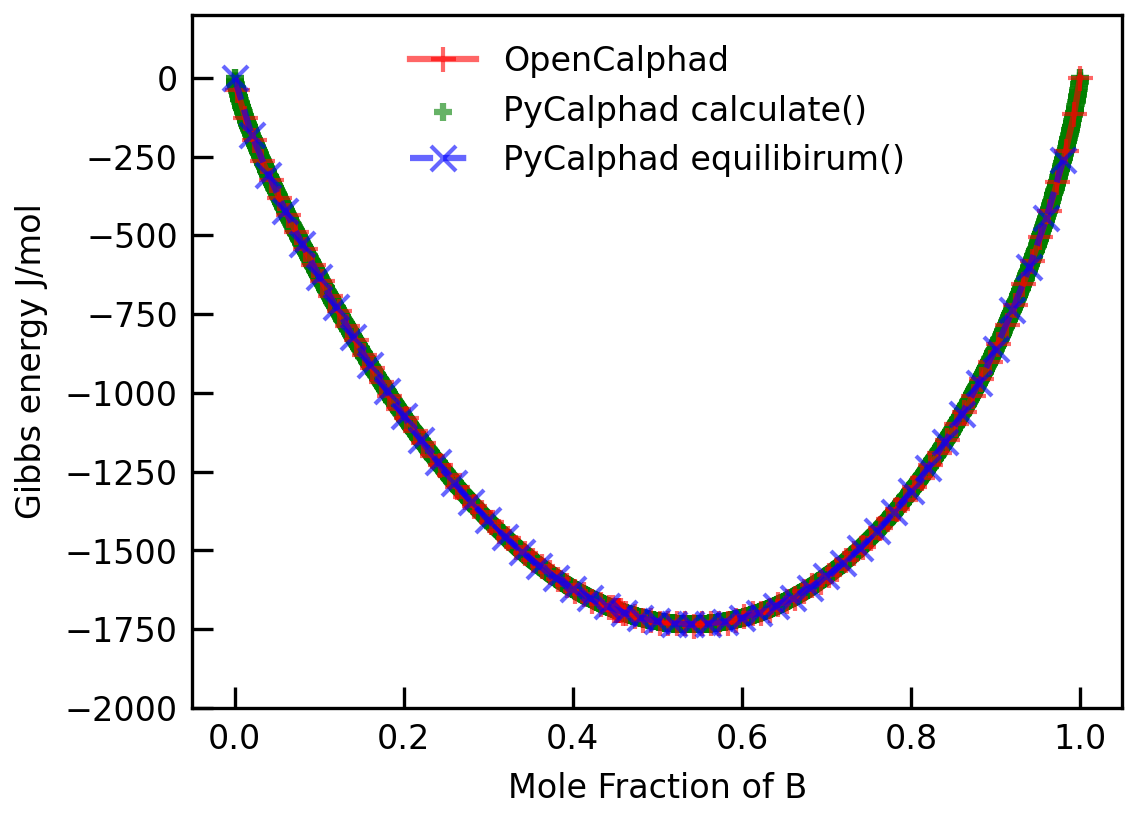

In [8]:
import matplotlib.pyplot as plt
plt.style.use('MQMQA_plot.mplstyle')
fig = plt.figure()
fig.gca().set_xlabel('Mole Fraction of B')
fig.gca().set_ylabel('Gibbs energy J/mol')
fig.gca().plot(x_op_fig1, y_op_fig1, '+-', markersize=6, color='red', alpha=0.6, label='OpenCalphad')

fig.gca().scatter(calc_res_1.X.sel(component='H'), calc_res_1.GM, marker='+', s=18, color='green', alpha=0.6, label='PyCalphad calculate()')
fig.gca().plot(eq_1.X.sel(component='H', vertex=0).squeeze(), eq_1.GM.squeeze(), 'x--', markerfacecolor='none', color='blue', markersize=6, alpha=0.6, label='PyCalphad equilibirum()')

fig.gca().set_ylim([-2000, 200])
plt.legend()
#plt.savefig('Fig1Py.png', dpi=200)

#### Entropy plot

In [9]:
dbf=Database('uniquac_test_fig1.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comps=['C', 'H', 'VA']
phases=['LIQUID']
cond={v.N: 1, v.P: 101325, v.T: 320, v.X('H'): (0, 1.02, 0.02)}
calc_res_1=calculate(dbf, comps, phases, P=101325, T=320, model=models, output='SM')
eq_1 = equilibrium(dbf, comps, phases, cond, model=models, output='SM')

/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/utils.py:54: RuntimeWarning: invalid value encountered in divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]
/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/lower_convex_hull.py:145: RuntimeWarning: invalid value encountered in scalar divide
  result_array_GM_values[it.multi_index] = new_energy / molesum


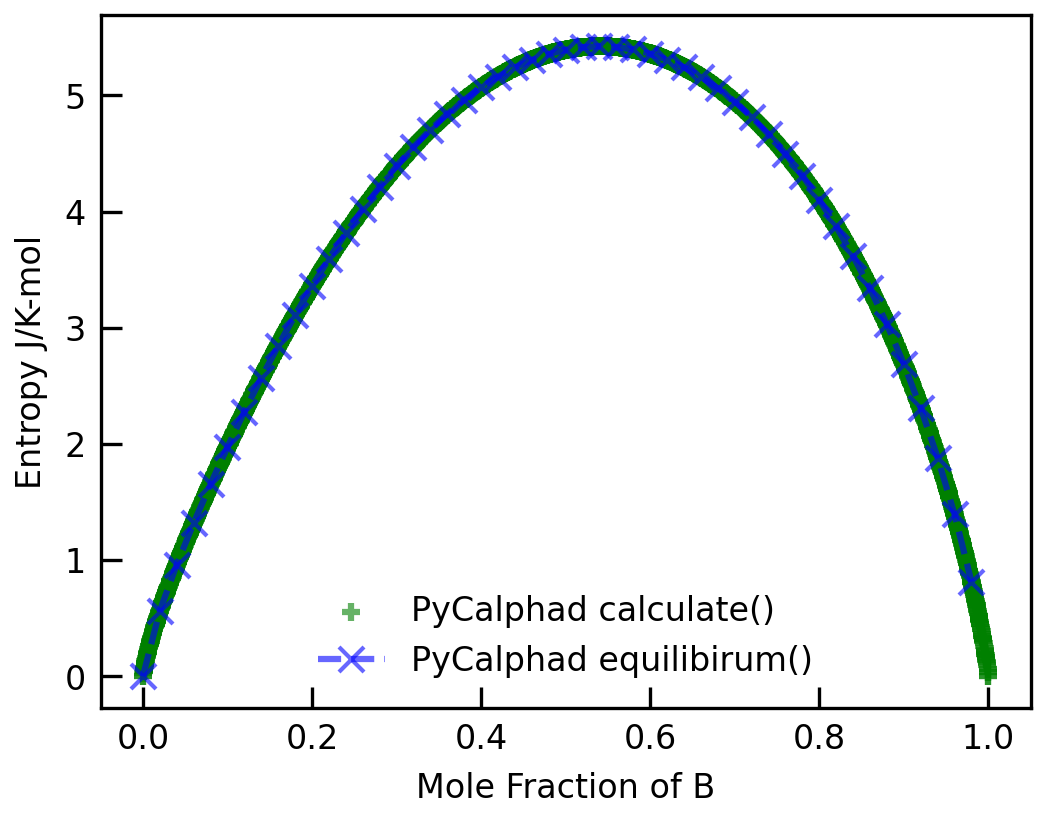

In [10]:
import matplotlib.pyplot as plt
plt.style.use('MQMQA_plot.mplstyle')
fig = plt.figure()
fig.gca().set_xlabel('Mole Fraction of B')
fig.gca().set_ylabel('Entropy J/K-mol')

fig.gca().scatter(calc_res_1.X.sel(component='H'), calc_res_1.SM, marker='+', s=18, color='green', alpha=0.6, label='PyCalphad calculate()')
fig.gca().plot(eq_1.X.sel(component='H', vertex=0).squeeze(), eq_1.SM.squeeze(), 'x--', markerfacecolor='none', color='blue', markersize=6, alpha=0.6, label='PyCalphad equilibirum()')

#fig.gca().set_ylim([-2000, 200])
plt.legend()
#plt.savefig('Fig1Py-S.png', dpi=200)

#### Activity

In [11]:
dbf=Database('uniquac_test_fig1.xml')
models = {'LIQUID': ModelUNIQUAC}
comps=['C', 'H']
phases=['LIQUID']
cond = {v.N: 1, v.P: 101325, v.T: 320, v.X('H'): (0, 1.02, 0.02)}
eq_acr_1 = equilibrium(dbf, comps, phases, cond, model=models, verbose=False)
ref_eq_acr_1 = equilibrium(dbf, ['C'], phases, {v.P: 101325, v.T: 320})
chempot_ref_C = ref_eq_acr_1.MU.sel(component='C').squeeze()
chempot_C = eq_acr_1.MU.sel(component='C').squeeze()
acr_C = np.exp((chempot_C - chempot_ref_C)/(8.31451*320))


ref_eq_acr_1 = equilibrium(dbf, ['H'], phases, {v.P: 101325, v.T: 320})
chempot_ref_H = ref_eq_acr_1.MU.sel(component='H').squeeze()
chempot_H = eq_acr_1.MU.sel(component='H').squeeze()
acr_H = np.exp((chempot_H - chempot_ref_H)/(8.31451*320))

/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/lower_convex_hull.py:145: RuntimeWarning: invalid value encountered in scalar divide
  result_array_GM_values[it.multi_index] = new_energy / molesum


In [30]:
oc_x_b_acr=[0.4527363, 0.4527463, 0.4527563, 0.4547563, 0.4567563, 0.4587563, 0.4627363, 0.4727363, 0.4827363, 0.4927363, 0.5027363, 0.5127363, 0.5227363, 0.5327363, 0.5427363, 0.5527363, 0.5627363, 0.5727363, 0.5827363, 0.5927363, 0.6027363, 0.6127363, 0.6227363, 0.6327363, 0.6427363, 0.6527363, 0.6627363, 0.6727363, 0.6827363, 0.6927363, 0.7027363, 0.7127363, 0.7227363, 0.7327363, 0.7427363, 0.7527363, 0.7627363, 0.7727363, 0.7827363, 0.7927363, 0.8027363, 0.8127363, 0.8227363, 0.8327363, 0.8427363, 0.8527363, 0.8627363, 0.8727363, 0.8827363, 0.8927363, 0.9027363, 0.9127363, 0.9227363, 0.9327363, 0.9427363, 0.9527363, 0.9627363, 0.9727363, 0.9827363, 0.9927363, 1.0000000, 0.4527363, 0.4527263, 0.4527163, 0.4507163, 0.4487163, 0.4467163, 0.4427363, 0.4327363, 0.4227363, 0.4127363, 0.4027363, 0.3927363, 0.3827363, 0.3727363, 0.3627363, 0.3527363, 0.3427363, 0.3327363, 0.3227363, 0.3127363, 0.3027363, 0.2927363, 0.2827363, 0.2727363, 0.2627363, 0.2527363, 0.2427363, 0.2327363, 0.2227363, 0.2127363, 0.2027363, 0.1927363, 0.1827363, 0.1727363, 0.1627363, 0.1527363, 0.1427363, 0.1327363, 0.1227363, 0.1127363, 0.1027363, 0.0927363, 0.0827363, 0.0727363, 0.0627363, 0.0527363, 0.0427363, 0.0327363, 0.0227363, 0.0127363, 0.0027363, 0.0000000, 0.4527363, 0.4527463, 0.4527563, 0.4547563, 0.4567563, 0.4587563, 0.4627363, 0.4727363, 0.4827363, 0.4927363, 0.5027363, 0.5127363, 0.5227363, 0.5327363, 0.5427363, 0.5527363, 0.5627363, 0.5727363, 0.5827363, 0.5927363, 0.6027363, 0.6127363, 0.6227363, 0.6327363, 0.6427363, 0.6527363, 0.6627363, 0.6727363, 0.6827363, 0.6927363, 0.7027363, 0.7127363, 0.7227363, 0.7327363, 0.7427363, 0.7527363, 0.7627363, 0.7727363, 0.7827363, 0.7927363, 0.8027363, 0.8127363, 0.8227363, 0.8327363, 0.8427363, 0.8527363, 0.8627363, 0.8727363, 0.8827363, 0.8927363, 0.9027363, 0.9127363, 0.9227363, 0.9327363, 0.9427363, 0.9527363, 0.9627363, 0.9727363, 0.9827363, 0.9927363, 1.0000000, 0.4527363, 0.4527263, 0.4527163, 0.4507163, 0.4487163, 0.4467163, 0.4427363, 0.4327363, 0.4227363, 0.4127363, 0.4027363, 0.3927363, 0.3827363, 0.3727363, 0.3627363, 0.3527363, 0.3427363, 0.3327363, 0.3227363, 0.3127363, 0.3027363, 0.2927363, 0.2827363, 0.2727363, 0.2627363, 0.2527363, 0.2427363, 0.2327363, 0.2227363, 0.2127363, 0.2027363, 0.1927363, 0.1827363, 0.1727363, 0.1627363, 0.1527363, 0.1427363, 0.1327363, 0.1227363, 0.1127363, 0.1027363, 0.0927363, 0.0827363, 0.0727363, 0.0627363, 0.0527363, 0.0427363, 0.0327363, 0.0227363, 0.0127363, 0.0027363, 0.0000000]
oc_acr_a=[0.6286729, 0.6286608, 0.6286488, 0.6262293, 0.6238081, 0.6213851, 0.6165584, 0.6044041, 0.5922167, 0.5800023, 0.5677668, 0.5555157, 0.5432542, 0.5309874, 0.5187199, 0.5064562, 0.4942005, 0.4819567, 0.4697285, 0.4575196, 0.4453331, 0.4331723, 0.4210400, 0.4089390, 0.3968719, 0.3848411, 0.3728489, 0.3608974, 0.3489887, 0.3371245, 0.3253066, 0.3135367, 0.3018163, 0.2901467, 0.2785293, 0.2669652, 0.2554556, 0.2440015, 0.2326039, 0.2212636, 0.2099814, 0.1987581, 0.1875943, 0.1764906, 0.1654475, 0.1544656, 0.1435453, 0.1326869, 0.1218907, 0.1111571, 0.1004863, 0.0898785, 0.0793339, 0.0688526, 0.0584347, 0.0480802, 0.0377892, 0.0275617, 0.0173977, 0.0072970, 0.0000000, 0.6286729, 0.6286850, 0.6286971, 0.6311146, 0.6335302, 0.6359439, 0.6407409, 0.6527551, 0.6647080, 0.6765914, 0.6883971, 0.7001162, 0.7117395, 0.7232574, 0.7346597, 0.7459359, 0.7570749, 0.7680654, 0.7788954, 0.7895526, 0.8000242, 0.8102970, 0.8203575, 0.8301919, 0.8397860, 0.8491254, 0.8581957, 0.8669824, 0.8754714, 0.8836485, 0.8915004, 0.8990145, 0.9061795, 0.9129856, 0.9194251, 0.9254932, 0.9311887, 0.9365151, 0.9414815, 0.9461048, 0.9504114, 0.9544398, 0.9582438, 0.9618972, 0.9654989, 0.9691810, 0.9731184, 0.9775426, 0.9827611, 0.9891839, 0.9973628, 1.0000000, 0.6286729, 0.6286608, 0.6286488, 0.6262293, 0.6238081, 0.6213851, 0.6165584, 0.6044041, 0.5922167, 0.5800023, 0.5677668, 0.5555157, 0.5432542, 0.5309874, 0.5187199, 0.5064562, 0.4942005, 0.4819567, 0.4697285, 0.4575196, 0.4453331, 0.4331723, 0.4210400, 0.4089390, 0.3968719, 0.3848411, 0.3728489, 0.3608974, 0.3489887, 0.3371245, 0.3253066, 0.3135367, 0.3018163, 0.2901467, 0.2785293, 0.2669652, 0.2554556, 0.2440015, 0.2326039, 0.2212636, 0.2099814, 0.1987581, 0.1875943, 0.1764906, 0.1654475, 0.1544656, 0.1435453, 0.1326869, 0.1218907, 0.1111571, 0.1004863, 0.0898785, 0.0793339, 0.0688526, 0.0584347, 0.0480802, 0.0377892, 0.0275617, 0.0173977, 0.0072970, 0.0000000, 0.6286729, 0.6286850, 0.6286971, 0.6311146, 0.6335302, 0.6359439, 0.6407409, 0.6527551, 0.6647080, 0.6765914, 0.6883971, 0.7001162, 0.7117395, 0.7232574, 0.7346597, 0.7459359, 0.7570749, 0.7680654, 0.7788954, 0.7895526, 0.8000242, 0.8102970, 0.8203575, 0.8301919, 0.8397860, 0.8491254, 0.8581957, 0.8669824, 0.8754714, 0.8836485, 0.8915004, 0.8990145, 0.9061795, 0.9129856, 0.9194251, 0.9254932, 0.9311887, 0.9365151, 0.9414815, 0.9461048, 0.9504114, 0.9544398, 0.9582438, 0.9618972, 0.9654989, 0.9691810, 0.9731184, 0.9775426, 0.9827611, 0.9891839, 0.9973628, 1.0000000]
oc_acr_b=[0.4306440, 0.4306540, 0.4306640, 0.4326678, 0.4346740, 0.4366824, 0.4406862, 0.4507845, 0.4609356, 0.4711360, 0.4813824, 0.4916716, 0.5020004, 0.5123659, 0.5227651, 0.5331953, 0.5436536, 0.5541373, 0.5646441, 0.5751712, 0.5857164, 0.5962773, 0.6068516, 0.6174372, 0.6280319, 0.6386338, 0.6492409, 0.6598512, 0.6704630, 0.6810745, 0.6916840, 0.7022898, 0.7128904, 0.7234843, 0.7340699, 0.7446459, 0.7552110, 0.7657637, 0.7763029, 0.7868274, 0.7973359, 0.8078274, 0.8183008, 0.8287551, 0.8391892, 0.8496023, 0.8599934, 0.8703617, 0.8807062, 0.8910263, 0.9013211, 0.9115900, 0.9218322, 0.9320470, 0.9422339, 0.9523921, 0.9625212, 0.9726206, 0.9826897, 0.9927280, 1.0000000, 0.4306440, 0.4306340, 0.4306240, 0.4286226, 0.4266237, 0.4246272, 0.4206616, 0.4107428, 0.4008913, 0.3911110, 0.3814060, 0.3717805, 0.3622386, 0.3527846, 0.3434232, 0.3341587, 0.3249959, 0.3159395, 0.3069944, 0.2981655, 0.2894579, 0.2808767, 0.2724270, 0.2641140, 0.2559431, 0.2479194, 0.2400481, 0.2323345, 0.2247833, 0.2173994, 0.2101871, 0.2031500, 0.1962913, 0.1896127, 0.1831144, 0.1767942, 0.1706466, 0.1646610, 0.1588200, 0.1530952, 0.1474429, 0.1417950, 0.1360466, 0.1300346, 0.1235027, 0.1160404, 0.1069773, 0.0951893, 0.0787310, 0.0541115, 0.0147865, 0.0000000, 0.4306440, 0.4306540, 0.4306640, 0.4326678, 0.4346740, 0.4366824, 0.4406862, 0.4507845, 0.4609356, 0.4711360, 0.4813824, 0.4916716, 0.5020004, 0.5123659, 0.5227651, 0.5331953, 0.5436536, 0.5541373, 0.5646441, 0.5751712, 0.5857164, 0.5962773, 0.6068516, 0.6174372, 0.6280319, 0.6386338, 0.6492409, 0.6598512, 0.6704630, 0.6810745, 0.6916840, 0.7022898, 0.7128904, 0.7234843, 0.7340699, 0.7446459, 0.7552110, 0.7657637, 0.7763029, 0.7868274, 0.7973359, 0.8078274, 0.8183008, 0.8287551, 0.8391892, 0.8496023, 0.8599934, 0.8703617, 0.8807062, 0.8910263, 0.9013211, 0.9115900, 0.9218322, 0.9320470, 0.9422339, 0.9523921, 0.9625212, 0.9726206, 0.9826897, 0.9927280, 1.0000000, 0.4306440, 0.4306340, 0.4306240, 0.4286226, 0.4266237, 0.4246272, 0.4206616, 0.4107428, 0.4008913, 0.3911110, 0.3814060, 0.3717805, 0.3622386, 0.3527846, 0.3434232, 0.3341587, 0.3249959, 0.3159395, 0.3069944, 0.2981655, 0.2894579, 0.2808767, 0.2724270, 0.2641140, 0.2559431, 0.2479194, 0.2400481, 0.2323345, 0.2247833, 0.2173994, 0.2101871, 0.2031500, 0.1962913, 0.1896127, 0.1831144, 0.1767942, 0.1706466, 0.1646610, 0.1588200, 0.1530952, 0.1474429, 0.1417950, 0.1360466, 0.1300346, 0.1235027, 0.1160404, 0.1069773, 0.0951893, 0.0787310, 0.0541115, 0.0147865, 0.0000000]

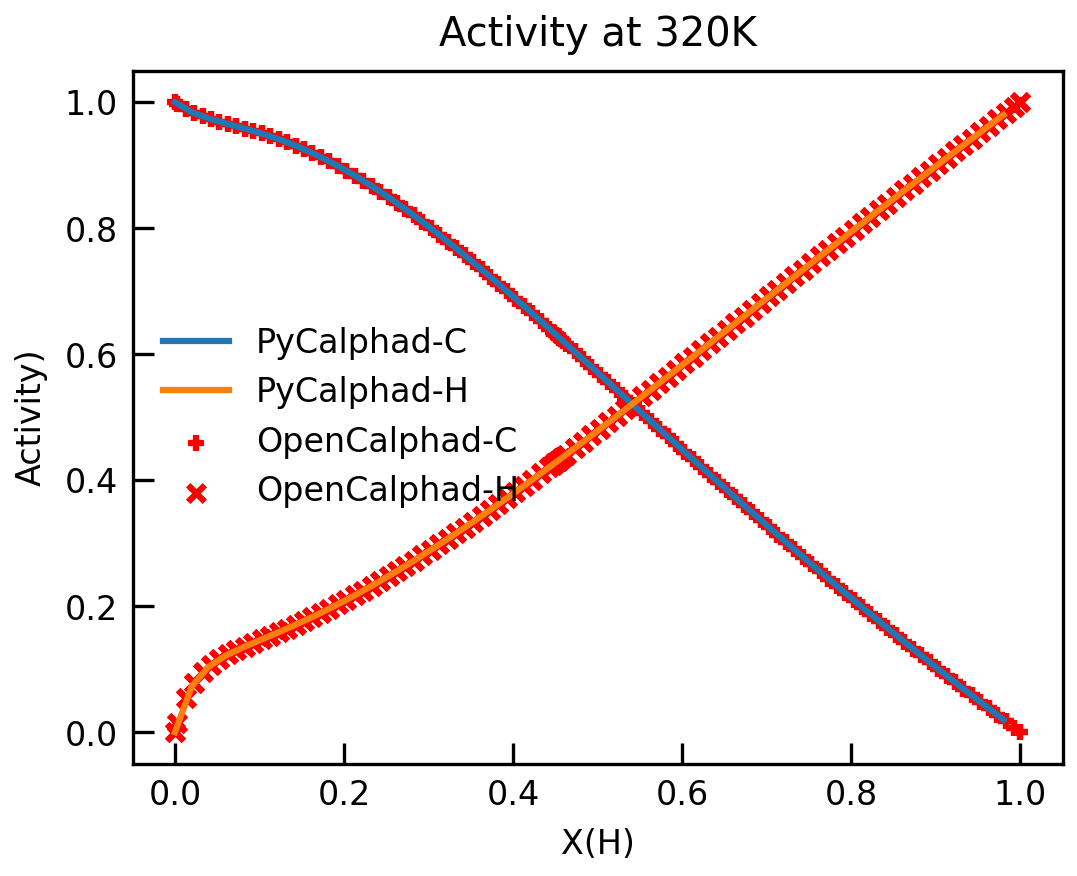

In [32]:
import matplotlib.pyplot as plt

plt.plot(eq_acr_1.X.sel(component='H', vertex=0).squeeze(), acr_C, label='PyCalphad-C')
plt.plot(eq_acr_1.X.sel(component='H', vertex=0).squeeze(), acr_H, label='PyCalphad-H')
# add experimental data
plt.scatter(oc_x_b_acr, oc_acr_a, marker='+', color='red', s=16, label='OpenCalphad-C')
plt.scatter(oc_x_b_acr, oc_acr_b, marker='x', color='red', s=16, label='OpenCalphad-H')
plt.xlabel('X(H)')
plt.ylabel('Activity)')
plt.title('Activity at 320K')
plt.legend(loc=0)

### Figure 2: res contribution to excess Gibbs energy

In [13]:
class ModelUNIQUAC(Model):
    
    contributions = [
        ("ref", "reference_energy"),
        ("idmix", "ideal_mixing_energy"),
        #("xsmix", "excess_mixing_energy"),
        ("cmbxmix", "combinatorial_contribution_excess_mixing_energy"),
        ("resxmix", "residual_contribution_excess_mixing_energy"),
    ]
    
    def __init__(self, dbe, comps, phase_name, parameters=None):
        self._dbe = dbe
        self._endmember_reference_model = None
        self.components = set()
        self.constituents = []
        self.phase_name = phase_name.upper()
        phase = dbe.phases[self.phase_name]
        self.site_ratios = list(phase.sublattices)
        active_species = unpack_components(dbe, comps)
        for idx, sublattice in enumerate(phase.constituents):
            subl_comps = set(sublattice).intersection(active_species)
            self.components |= subl_comps

        self.site_ratios = tuple(self.site_ratios)

        # Verify that this phase is still possible to build
        is_pure_VA = set()
        for sublattice in phase.constituents:
            sublattice_comps = set(sublattice).intersection(self.components)
            if len(sublattice_comps) == 0:
                # None of the components in a sublattice are active
                # We cannot build a model of this phase
                raise DofError(
                    '{0}: Sublattice {1} of {2} has no components in {3}' \
                    .format(self.phase_name, sublattice,
                            phase.constituents,
                            self.components))
            is_pure_VA.add(sum(set(map(lambda s : getattr(s, 'number_of_atoms'),sublattice_comps))))
            self.constituents.append(sublattice_comps)
        if sum(is_pure_VA) == 0:
            #The only possible component in a sublattice is vacancy
            #We cannot build a model of this phase
            raise DofError(
                '{0}: Sublattices of {1} contains only VA (VACUUM) constituents' \
                .format(self.phase_name, phase.constituents))
        self.components = sorted(self.components)
        desired_active_pure_elements = [list(x.constituents.keys()) for x in self.components]
        desired_active_pure_elements = [el.upper() for constituents in desired_active_pure_elements
                                        for el in constituents]
        self.pure_elements = sorted(set(desired_active_pure_elements))
        self.nonvacant_elements = [x for x in self.pure_elements if x != 'VA']

        # Convert string symbol names to Symbol objects
        # This makes xreplace work with the symbols dict
        symbols = {Symbol(s): val for s, val in dbe.symbols.items()}

        if parameters is not None:
            self._parameters_arg = parameters
            if isinstance(parameters, dict):
                symbols.update([(wrap_symbol(s), val) for s, val in parameters.items()])
            else:
                # Lists of symbols that should remain symbolic
                for s in parameters:
                    symbols.pop(wrap_symbol(s))
        else:
            self._parameters_arg = None

        self._symbols = {wrap_symbol(key): value for key, value in symbols.items()}

        self.models = OrderedDict()
        self.build_phase(dbe)

        for name, value in self.models.items():
            # XXX: xreplace hack because SymEngine seems to let Symbols slip in somehow
            self.models[name] = self.symbol_replace(value, symbols).xreplace(v.supported_variables_in_databases)

        self.site_fractions = sorted([x for x in self.variables if isinstance(x, v.SiteFraction)], key=str)
        self.state_variables = sorted([x for x in self.variables if not isinstance(x, v.SiteFraction)], key=str)
    @staticmethod


    def __eq__(self, other):
        if self is other:
            return True
        elif type(self) != type(other):
            return False
        else:
            return self.__dict__ == other.__dict__

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(repr(self))

    def moles(self, species, per_formula_unit=False):
        "Number of moles of species or elements."
        species = v.Species(species)
        is_pure_element = (len(species.constituents.keys()) == 1 and
                           list(species.constituents.keys())[0] == species.name)
        result = S.Zero
        normalization = S.Zero
        if is_pure_element:
            element = list(species.constituents.keys())[0]
            for idx, sublattice in enumerate(self.constituents):
                active = set(sublattice).intersection(self.components)
                result += self.site_ratios[idx] * \
                    sum(int(spec.number_of_atoms > 0) * spec.constituents.get(element, 0) * v.SiteFraction(self.phase_name, idx, spec)
                        for spec in active)
                normalization += self.site_ratios[idx] * \
                    sum(spec.number_of_atoms * v.SiteFraction(self.phase_name, idx, spec)
                        for spec in active)
        else:
            for idx, sublattice in enumerate(self.constituents):
                active = set(sublattice).intersection({species})
                if len(active) == 0:
                    continue
                result += self.site_ratios[idx] * sum(v.SiteFraction(self.phase_name, idx, spec) for spec in active)
                normalization += self.site_ratios[idx] * \
                    sum(int(spec.number_of_atoms > 0) * v.SiteFraction(self.phase_name, idx, spec)
                        for spec in active)
        if not per_formula_unit:
            return result / normalization
        else:
            return result

    @property
    def ast(self):
        "Return the full abstract syntax tree of the model."
        return Add(*list(self.models.values()))

    @property
    def variables(self):
        "Return state variables in the model."
        return sorted([x for x in self.ast.free_symbols if isinstance(x, v.StateVariable)], key=str)

    @property
    def degree_of_ordering(self):
        result = S.Zero
        site_ratio_normalization = S.Zero
        # Calculate normalization factor
        for idx, sublattice in enumerate(self.constituents):
            active = set(sublattice).intersection(self.components)
            subl_content = sum(int(spec.number_of_atoms > 0) * v.SiteFraction(self.phase_name, idx, spec) for spec in active)
            site_ratio_normalization += self.site_ratios[idx] * subl_content

        site_ratios = [c/site_ratio_normalization for c in self.site_ratios]
        for comp in self.components:
            if comp.number_of_atoms == 0:
                continue
            comp_result = S.Zero
            for idx, sublattice in enumerate(self.constituents):
                active = set(sublattice).intersection(set(self.components))
                if comp in active:
                    comp_result += site_ratios[idx] * Abs(v.SiteFraction(self.phase_name, idx, comp) - self.moles(comp)) / self.moles(comp)
            result += comp_result
        return result / sum(int(spec.number_of_atoms > 0) for spec in self.components)
    DOO = degree_of_ordering

    # Can be defined as a list of pre-computed first derivatives
    gradient = None

    # Note: In order-disorder phases, TC will always be the *disordered* value of TC
    curie_temperature = TC = S.Zero
    beta = BMAG = S.Zero
    neel_temperature = NT = S.Zero

    #pylint: disable=C0103
    # These are standard abbreviations from Thermo-Calc for these quantities
    energy = GM = property(lambda self: self.ast)
    formulaenergy = G = property(lambda self: self.ast * self._site_ratio_normalization)
    entropy = SM = property(lambda self: -self.GM.diff(v.T))
    enthalpy = HM = property(lambda self: self.GM - v.T*self.GM.diff(v.T))
    heat_capacity = CPM = property(lambda self: -v.T*self.GM.diff(v.T, v.T))
    #pylint: enable=C0103
    mixing_energy = GM_MIX = property(lambda self: self.GM - self.endmember_reference_model.GM)
    mixing_enthalpy = HM_MIX = property(lambda self: self.GM_MIX - v.T*self.GM_MIX.diff(v.T))
    mixing_entropy = SM_MIX = property(lambda self: -self.GM_MIX.diff(v.T))
    mixing_heat_capacity = CPM_MIX = property(lambda self: -v.T*self.GM_MIX.diff(v.T, v.T))
    @property
    def endmember_reference_model(self):
        """
        Return a Model containing only energy contributions from endmembers.

        Returns
        -------
        Model

        Notes
        -----
        The endmember_reference_model is used for ``_MIX`` properties of Model objects.
        It is defined such that subtracting it from the model will set the energy of the
        endmembers to zero. The endmember_reference_model AST can be modified in the
        same way as any Model.

        Partitioned models have energetic contributions from the ordered compound
        energies/interactions and the disordered compound energies/interactions.
        The endmembers to choose as the reference is ambiguous. If the current model has
        an ordered energy as part of a partitioned model, then the model energy
        contributions are set to ``nan``.

        The endmember reference model is built lazily and stored for later re-use
        because it needs to copy the Database and instantiate a new Model.
        """
        if self._endmember_reference_model is None:
            endmember_only_dbe = copy.deepcopy(self._dbe)
            endmember_only_dbe._parameters.remove(where('constituent_array').test(self._interaction_test))
            mod_endmember_only = self.__class__(endmember_only_dbe, self.components, self.phase_name, parameters=self._parameters_arg)
            # Ideal mixing contributions are always generated, so we need to set the
            # contribution of the endmember reference model to zero to preserve ideal
            # mixing in this model.
            mod_endmember_only.models['idmix'] = 0
            if self.models.get('ord', S.Zero) != S.Zero:
                warnings.warn(
                    f"{self.phase_name} is a partitioned model with an ordering energy "
                    "contribution. The choice of endmembers for the endmember "
                    "reference model used by `_MIX` properties is ambiguous for "
                    "partitioned models. The `Model.set_reference_state` method is a "
                    "better choice for computing mixing energy. See "
                    "https://pycalphad.org/docs/latest/examples/ReferenceStateExamples.html "
                    "for an example."
                )
                for k in mod_endmember_only.models.keys():
                    mod_endmember_only.models[k] = float('nan')
            self._endmember_reference_model = mod_endmember_only
        return self._endmember_reference_model

    def get_internal_constraints(self):
        constraints = []
        # Site fraction balance
        for idx, sublattice in enumerate(self.constituents):
            constraints.append(sum(v.SiteFraction(self.phase_name, idx, spec) for spec in sublattice) - 1)
        # Charge balance for all phases that are charged
        has_charge = len({sp for sp in self.components if sp.charge != 0}) > 0
        constant_site_ratios = True
        # The only implementation with variable site ratios is the two-sublattice ionic liquid.
        # This check is convenient for detecting 2SL ionic liquids without keeping other state.
        # Because 2SL ionic liquids charge balance 'automatically', we do not need to enforce charge balance.
        for sr in self.site_ratios:
            try:
                float(sr)
            except (TypeError, RuntimeError):
                constant_site_ratios = False
        # For all other cases where charge is present, we do need to add charge balance.
        if constant_site_ratios and has_charge:
            total_charge = 0
            for idx, (sublattice, site_ratio) in enumerate(zip(self.constituents, self.site_ratios)):
                total_charge += sum(v.SiteFraction(self.phase_name, idx, spec) * spec.charge * site_ratio
                                    for spec in sublattice)
            constraints.append(total_charge)
        return constraints

    def _array_validity(self, constituent_array):
        """
        Return True if the constituent_array contains only active species of the current Model instance.
        """
        for param_sublattice, model_sublattice in zip(constituent_array, self.constituents):
            if not (set(param_sublattice).issubset(model_sublattice) or (param_sublattice[0] == v.Species('*'))):
                return False
        return True

    def _purity_test(self, constituent_array):
        """
        Return True if the constituent_array is valid and has exactly one
        species in every sublattice.
        """
        if not self._array_validity(constituent_array):
            return False
        return not any(len(sublattice) != 1 for sublattice in constituent_array)

    def _interaction_test(self, constituent_array):
        """
        Return True if the constituent_array is valid and has more than one
        species in at least one sublattice.
        """
        if not self._array_validity(constituent_array):
            return False
        return any([len(sublattice) > 1 for sublattice in constituent_array])

    @property
    def _site_ratio_normalization(self):
        """
        Calculates the normalization factor based on the number of sites
        in each sublattice.
        """
        site_ratio_normalization = S.Zero
        # Calculate normalization factor
        for idx, sublattice in enumerate(self.constituents):
            active = set(sublattice).intersection(self.components)
            subl_content = sum(spec.number_of_atoms * v.SiteFraction(self.phase_name, idx, spec) for spec in active)
            site_ratio_normalization += self.site_ratios[idx] * subl_content
        return site_ratio_normalization



    def redlich_kister_sum(self, phase, param_search, param_query):
        """
        Construct parameter in Redlich-Kister polynomial basis, using
        the Muggianu ternary parameter extension.
        """
        rk_terms = []

        # search for desired parameters
        params = param_search(param_query)
        for param in params:
            # iterate over every sublattice
            mixing_term = S.One
            for subl_index, comps in enumerate(param['constituent_array']):
                comp_symbols = None
                # convert strings to symbols
                if comps[0] == v.Species('*'):
                    # Handle wildcards in constituent array
                    comp_symbols = \
                        [
                            v.SiteFraction(phase.name, subl_index, comp)
                            for comp in sorted(set(phase.constituents[subl_index])\
                                .intersection(self.components))
                        ]
                    mixing_term *= Add(*comp_symbols)
                else:
                    if (
                        phase.model_hints.get('ionic_liquid_2SL', False) and  # This is an ionic 2SL
                        len(param['constituent_array']) == 1 and  # There's only one sublattice
                        all(const.charge == 0 for const in param['constituent_array'][0])  # All constituents are neutral
                    ):
                        # The constituent array is all neutral anion species in what would be the
                        # second sublattice. TDB syntax allows for specifying neutral species with
                        # one sublattice model. Set the sublattice index to 1 for the purpose of
                        # site fractions.
                        subl_index = 1
                    comp_symbols = \
                        [
                            v.SiteFraction(phase.name, subl_index, comp)
                            for comp in comps
                        ]
                    if phase.model_hints.get('ionic_liquid_2SL', False):  # This is an ionic 2SL
                        # We need to special case sorting for this model, because the constituents
                        # should not be alphabetically sorted. The model should be (C)(A, Va, B)
                        # for cations (C), anions (A), vacancies (Va) and neutrals (B). Thus the
                        # second sublattice should be sorted by species with charge, then by
                        # vacancies, if present, then by neutrals. Hint: in Thermo-Calc, using
                        # `set-start-constitution` for a phase will prompt you to enter site
                        # fractions for species in the order they are sorted internally within
                        # Thermo-Calc. This can be used to verify sorting behavior.

                        # Assume that the constituent array is already in sorted order
                        # alphabetically, so we need to rearrange the species first by charged
                        # species, then VA, then netural species. Since the cation sublattice
                        # should only have charged species by definition, this is equivalent to
                        # a no-op for the first sublattice.
                        charged_symbols = [sitefrac for sitefrac in comp_symbols if sitefrac.species.charge != 0 and sitefrac.species.number_of_atoms > 0]
                        va_symbols = [sitefrac for sitefrac in comp_symbols if sitefrac.species == v.Species('VA')]
                        neutral_symbols = [sitefrac for sitefrac in comp_symbols if sitefrac.species.charge == 0 and sitefrac.species.number_of_atoms > 0]
                        comp_symbols = charged_symbols + va_symbols + neutral_symbols

                    mixing_term *= Mul(*comp_symbols)
                # is this a higher-order interaction parameter?
                if len(comps) == 2 and param['parameter_order'] > 0:
                    # interacting sublattice, add the interaction polynomial
                    mixing_term *= Pow(comp_symbols[0] - \
                        comp_symbols[1], param['parameter_order'])
                if len(comps) == 3:
                    # 'parameter_order' is an index to a variable when
                    # we are in the ternary interaction parameter case

                    # NOTE: The commercial software packages seem to have
                    # a "feature" where, if only the zeroth
                    # parameter_order term of a ternary parameter is specified,
                    # the other two terms are automatically generated in order
                    # to make the parameter symmetric.
                    # In other words, specifying only this parameter:
                    # PARAMETER G(FCC_A1,AL,CR,NI;0) 298.15  +30300; 6000 N !
                    # Actually implies:
                    # PARAMETER G(FCC_A1,AL,CR,NI;0) 298.15  +30300; 6000 N !
                    # PARAMETER G(FCC_A1,AL,CR,NI;1) 298.15  +30300; 6000 N !
                    # PARAMETER G(FCC_A1,AL,CR,NI;2) 298.15  +30300; 6000 N !
                    #
                    # If either 1 or 2 is specified, no implicit parameters are
                    # generated.
                    # We need to handle this case.
                    if param['parameter_order'] == 0:
                        # are _any_ of the other parameter_orders specified?
                        ternary_param_query = (
                            (where('phase_name') == param['phase_name']) & \
                            (where('parameter_type') == \
                                param['parameter_type']) & \
                            (where('constituent_array') == \
                                param['constituent_array'])
                        )
                        other_tern_params = param_search(ternary_param_query)
                        if len(other_tern_params) == 1 and \
                            other_tern_params[0] == param:
                            # only the current parameter is specified
                            # We need to generate the other two parameters.
                            order_one = copy.copy(param)
                            order_one['parameter_order'] = 1
                            order_two = copy.copy(param)
                            order_two['parameter_order'] = 2
                            # Add these parameters to our iteration.
                            params.extend((order_one, order_two))
                    # Include variable indicated by parameter order index
                    # Perform Muggianu adjustment to site fractions
                    mixing_term *= comp_symbols[param['parameter_order']].subs(
                        self._Muggianu_correction_dict(comp_symbols))
            if phase.model_hints.get('ionic_liquid_2SL', False):
                # Special normalization rules for parameters apply under this model
                # If there are no anions present in the anion sublattice (only VA and neutral
                # species), then the energy has an additional Q*y(VA) term
                anions_present = any([m.species.charge < 0 for m in mixing_term.free_symbols])
                if not anions_present:
                    pair_rule = {}
                    # Cation site fractions must always appear with vacancy site fractions
                    va_subls = [(v.Species('VA') in phase.constituents[idx]) for idx in range(len(phase.constituents))]
                    # The last index that contains a vacancy
                    va_subl_idx = (len(phase.constituents) - 1) - va_subls[::-1].index(True)
                    va_present = any((v.Species('VA') in c) for c in param['constituent_array'])
                    if va_present and (max(len(c) for c in param['constituent_array']) == 1):
                        # No need to apply pair rule for VA-containing endmember
                        pass
                    elif va_subl_idx > -1:
                        for sym in mixing_term.free_symbols:
                            if sym.species.charge > 0:
                                pair_rule[sym] = sym * v.SiteFraction(sym.phase_name, va_subl_idx, v.Species('VA'))
                    mixing_term = mixing_term.xreplace(pair_rule)
                    # This parameter is normalized differently due to the variable charge valence of vacancies
                    mixing_term *= self.site_ratios[va_subl_idx]
            param_val = param['parameter']
            if isinstance(param_val, Piecewise):
                # Eliminate redundant Piecewise and extrapolate beyond temperature limits
                filtered_args = [expr for expr, cond in zip(*[iter(param_val.args)]*2) if not ((cond == S.true) and (expr == S.Zero))]
                if len(filtered_args) == 1:
                    param_val = filtered_args[0]
            rk_terms.append(mixing_term * param_val)
        return Add(*rk_terms)

    def reference_energy(self, dbe):
        """
        Returns the weighted average of the endmember energies
        in symbolic form.
        """
        pure_param_query = (
            (where('phase_name') == self.phase_name) & \
            (where('parameter_type') == "UQCG") & \
            (where('constituent_array').test(self._purity_test))
        )
        phase = dbe.phases[self.phase_name]
        param_search = dbe.search
        pure_energy_term = self.redlich_kister_sum(phase, param_search,
                                                   pure_param_query)
        return pure_energy_term / self._site_ratio_normalization


    def ideal_mixing_energy(self, dbe):
        #pylint: disable=W0613
        """
        Returns the ideal mixing energy in symbolic form.
        """
        phase = dbe.phases[self.phase_name]
        site_ratios = self.site_ratios
        ideal_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            ratio = site_ratios[subl_index]
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                # We lose some precision here, but this makes the limit behave nicely
                # We're okay until fractions of about 1e-12 (platform-dependent)
                mixing_term = Piecewise((sitefrac*log(sitefrac),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
                ideal_mixing_term += (mixing_term*ratio)
        ideal_mixing_term *= (v.R * v.T)
        return ideal_mixing_term / self._site_ratio_normalization
    
    def _rx_i(self, dbe, species: v.Species):
        terms=S.Zero
        phase=dbe.phases[self.phase_name]
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        uqcr_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCR") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcr_param_query)
        for subl_index, sublattice in enumerate(phase.constituents):
            sitefrac = v.SiteFraction(phase.name, subl_index, species)
            for param in params:
                if param["constituent_array"][0][0] == species:
                    r_i=param["parameter"]
                    terms=Piecewise((sitefrac*r_i,
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
        return terms
    
    def _rx_sum(self, dbe):
        rx_sum=S.Zero
        phase=dbe.phases[self.phase_name]
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                rx_sum+=self._rx_i(dbe, comp)
        return rx_sum
    
    def _phi_i(self, dbe, species: v.Species):
        return self._rx_i(dbe, species)/self._rx_sum(dbe)
    
    
    def q_i(self, dbe, species: v.Species):
         
        uqcq_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCQ") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcq_param_query)
        for param in params:
            if param["constituent_array"][0][0] == species:
                 q=param["parameter"]           
        return q
    
    
    def _qx_i(self, dbe, species: v.Species):
        terms=S.Zero
        phase=dbe.phases[self.phase_name]
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            sitefrac = v.SiteFraction(phase.name, subl_index, species)
            terms=Piecewise((sitefrac*self.q_i(dbe, species),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
        return terms
    
    def _qx_sum(self, dbe):
        qx_sum=S.Zero
        phase=dbe.phases[self.phase_name]
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                qx_sum+=self._qx_i(dbe, comp)
        return qx_sum
    
    def _theta_i(self, dbe, species: v.Species):
        return self._qx_i(dbe, species)/self._qx_sum(dbe)
    
    
    def cmb_p1(self, dbe):
        phase = dbe.phases[self.phase_name]
        cmb_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term = Piecewise((sitefrac*log(self._phi_i(dbe,comp)/sitefrac),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        ) 
                cmb_mixing_term += (mixing_term)
        cmb_mixing_term *= (v.R * v.T)
        return cmb_mixing_term / self._site_ratio_normalization
    
    def Z(self, dbe, species: v.Species):
        #phase=dbe.phases[self.phase_name]
        #param_search = dbe.search
        uqcz_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCZ") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqcz_param_query)
        for param in params:
            if param["constituent_array"][0][0] == species:
                z=float(param["parameter"])
        return z
    
    def cmb_p2(self, dbe):
        phase = dbe.phases[self.phase_name]
        cmb_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term = Piecewise((self.Z(dbe,comp)/2*sitefrac*self.q_i(dbe,comp)*log(self._theta_i(dbe,comp)/self._phi_i(dbe,comp)),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        ) 
                
                cmb_mixing_term += (mixing_term)
        cmb_mixing_term *= (v.R * v.T)
        return cmb_mixing_term / self._site_ratio_normalization
    
    def combinatorial_contribution_excess_mixing_energy(self, dbe):
        Gcmb=self.cmb_p1(dbe)+self.cmb_p2(dbe)
        return Gcmb
    
    def _tau_ji(self, dbe, i: v.Species, j: v.Species):
        #phase=dbe.phases[self.phase_name]
        #param_search = dbe.search
        #In the database, the i is marked with Exponents 1.0
        uqct_param_query=(
            (where("phase_name") == self.phase_name) & \
            (where("parameter_type") == "UQCT") & \
            (where("constituent_array").test(self._array_validity))
        )
        params = dbe._parameters.search(uqct_param_query)
        tau_ji=S.Zero
        for param in params:
            if i in param["constituent_array"][0]:
                if j in param["constituent_array"][0]:
                    comps = param["constituent_array"][0]
                    exs = param["exponents"]
                    combination=sorted(zip(exs, comps))
                    for ii in combination:
                        if ii[1] == i:
                            if ii[0]==1:
                                tau_ji=param['parameter']           
        return tau_ji
        
    def _pair_ij(self, dbe, i: v.Species):
        pairs=list(itertools.permutations(self.components, 2))
        i_pair=list()
        for ii in pairs:
            if ii[0] == i:
                i_pair.append(ii)
        return i_pair
                
    def _rho_i(self, dbe, i: v.Species):
        phase=dbe.phases[self.phase_name]
        terms=S.Zero
        for i_pair in self._pair_ij(dbe, i):
            ti=i_pair[0]
            tj=i_pair[1]
            tau_ji=self._tau_ji(dbe, ti, tj)
            terms+=tau_ji*self._theta_i(dbe, tj)
        terms+=self._theta_i(dbe, i)
        return terms
    
    def residual_contribution_excess_mixing_energy(self, dbe):
        phase = dbe.phases[self.phase_name]
        res_mixing_term = S.Zero
        sitefrac_limit = Float(MIN_SITE_FRACTION/10.)
        for subl_index, sublattice in enumerate(phase.constituents):
            active_comps = set(sublattice).intersection(self.components)
            for comp in active_comps:
                sitefrac = \
                    v.SiteFraction(phase.name, subl_index, comp)
                mixing_term =  Piecewise((sitefrac*self.q_i(dbe,comp)*log(self._rho_i(dbe,comp)),
                                         StrictGreaterThan(sitefrac, sitefrac_limit)), (0, True),
                                        )
                res_mixing_term += (mixing_term)
        res_mixing_term *= (v.R * v.T * (-1))
        return res_mixing_term / self._site_ratio_normalization
    
    def excess_mixing_energy(self, dbe):
        return self.residual_contribution_excess_mixing_energy(dbe)+self.combinatorial_contribution_excess_mixing_energy(dbe)
        
    def build_phase(self, dbe):
        """
        Generate the symbolic form of all the contributions to this phase.

        Parameters
        ----------
        dbe : 'pycalphad.io.Database'
        """
        self.models.clear()
        for key, value in self.__class__.contributions:
            self.models[key] = S(getattr(self, value)(dbe))

#### Figure 2 Gibbs energy

In [14]:
dbf=Database('uniquac_test_fig2.xml')
models={'LIQUID': ModelUNIQUAC}
comps=['C','H','VA']
phases=['LIQUID']
calc_res_2=calculate(dbf, comps, phases, P=101325, T=400, model=models, output='GM')
conds = {v.N: 1, v.P: 101325, v.T: 400,  v.X('H'): (0, 1.02, 0.02)}
eq_2=equilibrium(dbf, comps, phases, conds, model=models)

/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/utils.py:54: RuntimeWarning: invalid value encountered in divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]
/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/lower_convex_hull.py:145: RuntimeWarning: invalid value encountered in scalar divide
  result_array_GM_values[it.multi_index] = new_energy / molesum


In [15]:
x_op_fig22=[1.10E-12, 2.74E-03, 1.27E-02, 2.27E-02, 3.27E-02, 4.27E-02, 5.27E-02, 6.27E-02, 7.27E-02, 8.27E-02, 9.27E-02, 1.03E-01, 1.13E-01, 1.23E-01, 1.33E-01, 1.43E-01, 1.53E-01, 1.63E-01, 1.73E-01, 1.83E-01, 1.93E-01, 2.03E-01, 2.13E-01, 2.23E-01, 2.33E-01, 2.43E-01, 2.53E-01, 2.63E-01, 2.73E-01, 2.83E-01, 2.93E-01, 3.03E-01, 3.13E-01, 3.23E-01, 3.33E-01, 3.43E-01, 3.53E-01, 3.63E-01, 3.73E-01, 3.83E-01, 3.93E-01, 4.03E-01, 4.13E-01, 4.23E-01, 4.33E-01, 4.43E-01, 4.47E-01, 4.49E-01, 4.51E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.55E-01, 4.57E-01, 4.59E-01, 4.63E-01, 4.73E-01, 4.83E-01, 4.93E-01, 5.03E-01, 5.13E-01, 5.23E-01, 5.33E-01, 5.43E-01, 5.53E-01, 5.63E-01, 5.73E-01, 5.83E-01, 5.93E-01, 6.03E-01, 6.13E-01, 6.23E-01, 6.33E-01, 6.43E-01, 6.53E-01, 6.63E-01, 6.73E-01, 6.83E-01, 6.93E-01, 7.03E-01, 7.13E-01, 7.23E-01, 7.33E-01, 7.43E-01, 7.53E-01, 7.63E-01, 7.73E-01, 7.83E-01, 7.93E-01, 8.03E-01, 8.13E-01, 8.23E-01, 8.33E-01, 8.43E-01, 8.53E-01, 8.63E-01, 8.73E-01, 8.83E-01, 8.93E-01, 9.03E-01, 9.13E-01, 9.23E-01, 9.33E-01, 9.43E-01, 9.53E-01, 9.63E-01, 9.73E-01, 9.83E-01, 9.93E-01, 1.00E+00]
y_op_fig22=[-9.70E-08, -4.44E+01, -1.42E+02, -2.11E+02, -2.66E+02, -3.12E+02, -3.50E+02, -3.84E+02, -4.13E+02, -4.39E+02, -4.62E+02, -4.82E+02, -5.00E+02, -5.16E+02, -5.30E+02, -5.43E+02, -5.55E+02, -5.65E+02, -5.74E+02, -5.82E+02, -5.90E+02, -5.96E+02, -6.02E+02, -6.07E+02, -6.12E+02, -6.16E+02, -6.20E+02, -6.23E+02, -6.26E+02, -6.28E+02, -6.31E+02, -6.33E+02, -6.34E+02, -6.36E+02, -6.37E+02, -6.38E+02, -6.39E+02, -6.40E+02, -6.40E+02, -6.41E+02, -6.41E+02, -6.42E+02, -6.42E+02, -6.42E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.43E+02, -6.42E+02, -6.42E+02, -6.42E+02, -6.41E+02, -6.41E+02, -6.40E+02, -6.39E+02, -6.38E+02, -6.37E+02, -6.36E+02, -6.35E+02, -6.33E+02, -6.31E+02, -6.29E+02, -6.27E+02, -6.24E+02, -6.21E+02, -6.18E+02, -6.14E+02, -6.09E+02, -6.05E+02, -5.99E+02, -5.93E+02, -5.86E+02, -5.78E+02, -5.69E+02, -5.59E+02, -5.49E+02, -5.36E+02, -5.23E+02, -5.08E+02, -4.90E+02, -4.71E+02, -4.50E+02, -4.25E+02, -3.98E+02, -3.66E+02, -3.30E+02, -2.88E+02, -2.37E+02, -1.76E+02, -9.44E+01, -9.70E-08]
x_op_fig21=[1.10E-12, 2.74E-03, 1.27E-02, 2.27E-02, 3.27E-02, 4.27E-02, 5.27E-02, 6.27E-02, 7.27E-02, 8.27E-02, 9.27E-02, 1.03E-01, 1.13E-01, 1.23E-01, 1.33E-01, 1.43E-01, 1.53E-01, 1.63E-01, 1.73E-01, 1.83E-01, 1.93E-01, 2.03E-01, 2.13E-01, 2.23E-01, 2.33E-01, 2.43E-01, 2.53E-01, 2.63E-01, 2.73E-01, 2.83E-01, 2.93E-01, 3.03E-01, 3.13E-01, 3.23E-01, 3.33E-01, 3.43E-01, 3.53E-01, 3.63E-01, 3.73E-01, 3.83E-01, 3.93E-01, 4.03E-01, 4.13E-01, 4.23E-01, 4.33E-01, 4.43E-01, 4.47E-01, 4.49E-01, 4.51E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.55E-01, 4.57E-01, 4.59E-01, 4.63E-01, 4.73E-01, 4.83E-01, 4.93E-01, 5.03E-01, 5.13E-01, 5.23E-01, 5.33E-01, 5.43E-01, 5.53E-01, 5.63E-01, 5.73E-01, 5.83E-01, 5.93E-01, 6.03E-01, 6.13E-01, 6.23E-01, 6.33E-01, 6.43E-01, 6.53E-01, 6.63E-01, 6.73E-01, 6.83E-01, 6.93E-01, 7.03E-01, 7.13E-01, 7.23E-01, 7.33E-01, 7.43E-01, 7.53E-01, 7.63E-01, 7.73E-01, 7.83E-01, 7.93E-01, 8.03E-01, 8.13E-01, 8.23E-01, 8.33E-01, 8.43E-01, 8.53E-01, 8.63E-01, 8.73E-01, 8.83E-01, 8.93E-01, 9.03E-01, 9.13E-01, 9.23E-01, 9.33E-01, 9.43E-01, 9.53E-01, 9.63E-01, 9.73E-01, 9.83E-01, 9.93E-01, 1.00E+00]
y_op_fig21=[-9.55E-08, -4.07E+01, -1.25E+02, -1.81E+02, -2.23E+02, -2.56E+02, -2.83E+02, -3.05E+02, -3.23E+02, -3.37E+02, -3.49E+02, -3.58E+02, -3.66E+02, -3.72E+02, -3.76E+02, -3.79E+02, -3.81E+02, -3.82E+02, -3.83E+02, -3.83E+02, -3.82E+02, -3.80E+02, -3.78E+02, -3.76E+02, -3.73E+02, -3.71E+02, -3.68E+02, -3.65E+02, -3.61E+02, -3.58E+02, -3.55E+02, -3.51E+02, -3.48E+02, -3.44E+02, -3.41E+02, -3.38E+02, -3.35E+02, -3.32E+02, -3.29E+02, -3.27E+02, -3.24E+02, -3.22E+02, -3.20E+02, -3.18E+02, -3.16E+02, -3.15E+02, -3.14E+02, -3.14E+02, -3.14E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.13E+02, -3.12E+02, -3.12E+02, -3.11E+02, -3.11E+02, -3.11E+02, -3.11E+02, -3.11E+02, -3.12E+02, -3.13E+02, -3.14E+02, -3.15E+02, -3.17E+02, -3.19E+02, -3.21E+02, -3.23E+02, -3.25E+02, -3.28E+02, -3.31E+02, -3.34E+02, -3.37E+02, -3.40E+02, -3.43E+02, -3.46E+02, -3.50E+02, -3.53E+02, -3.56E+02, -3.60E+02, -3.63E+02, -3.66E+02, -3.69E+02, -3.72E+02, -3.75E+02, -3.77E+02, -3.79E+02, -3.81E+02, -3.82E+02, -3.83E+02, -3.83E+02, -3.82E+02, -3.80E+02, -3.78E+02, -3.74E+02, -3.69E+02, -3.62E+02, -3.53E+02, -3.43E+02, -3.30E+02, -3.13E+02, -2.94E+02, -2.69E+02, -2.39E+02, -2.01E+02, -1.53E+02, -8.46E+01, -9.55E-08]

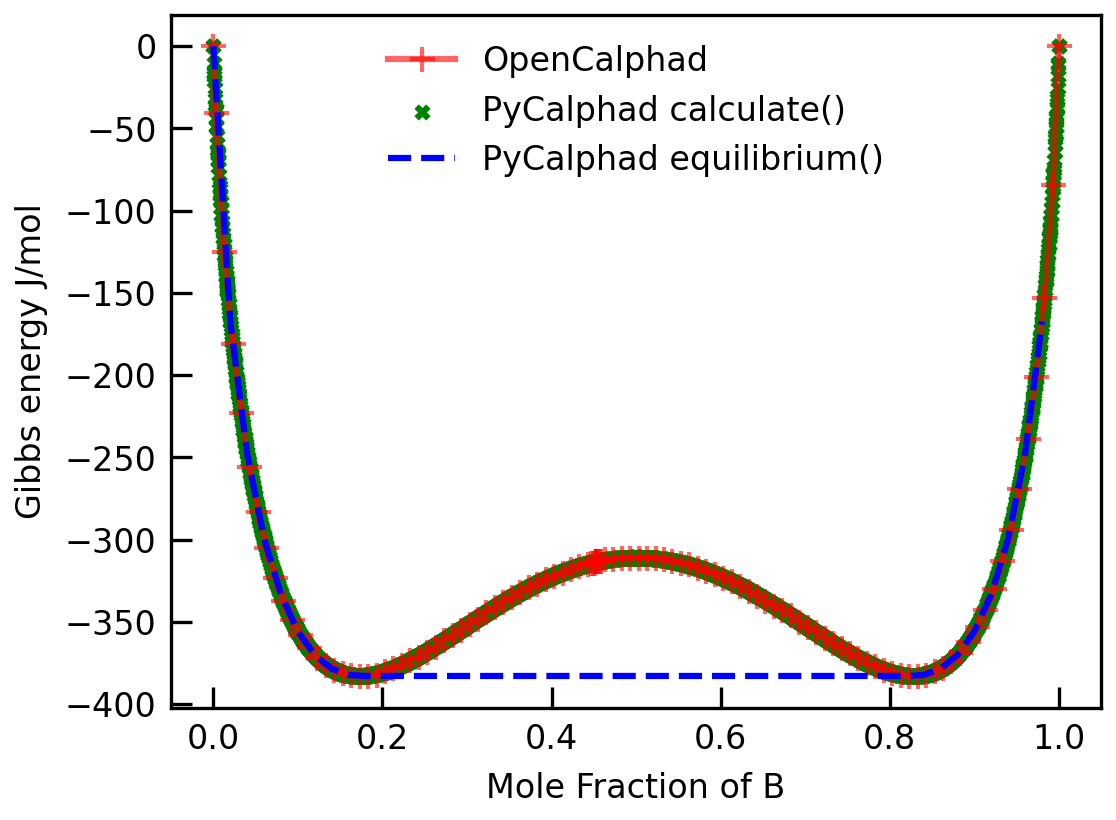

In [16]:
import matplotlib.pyplot as plt
plt.style.use('MQMQA_plot.mplstyle')
fig = plt.figure()
fig.gca().set_xlabel('Mole Fraction of B')
fig.gca().set_ylabel('Gibbs energy J/mol')
fig.gca().plot(x_op_fig21, y_op_fig21, '+-', markersize=6, color='red', alpha=0.6, label='OpenCalphad')
fig.gca().scatter(calc_res_2.X.sel(component='H'), calc_res_2.GM, marker='x', s=8, color='green',label='PyCalphad calculate()')
fig.gca().plot(eq_2.X_H.squeeze(), eq_2.GM.squeeze(), '--', markerfacecolor='none', color='blue', markersize=8, label='PyCalphad equilibrium()')

plt.legend()
#plt.savefig('Fig2Py.png', dpi=200)
plt.show()

In [17]:
eq_2

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_H: 51, vertex: 3, component: 2,
                internal_dof: 2)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 400.0
  * X_H        (X_H) float64 1e-10 0.02 0.04 0.06 0.08 ... 0.94 0.96 0.98 1.0
  * vertex     (vertex) int64 0 1 2
  * component  (component) <U1 'C' 'H'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_H, vertex) float64 1.0 nan nan 1.0 ... nan nan nan
    GM         (N, P, T, X_H) float64 -7.18e-06 -167.4 -248.1 ... -167.4 nan
    MU         (N, P, T, X_H, component) float64 -3.326e-07 -6.847e+04 ... nan
    X          (N, P, T, X_H, vertex, component) float64 1.0 1e-10 ... nan nan
    Y          (N, P, T, X_H, vertex, internal_dof) float64 1.0 1e-10 ... nan
    Phase      (N, P, T, X_H, vertex) <U6 'LIQUID' '' '' 'LIQUID' ... '' '' ''
Attributes:
    engine:   pycalphad 0.1.dev1906+g2eaab13.d20240215
    created:  2024-02-15T15:54:01.648691

### Figure 3 Gibbs energy

In [18]:
dbf=Database('uniquac_test_fig3.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comps=['C', 'H', 'VA']
phases=['LIQUID']
calc_res_3=calculate(dbf, comps, phases, P=101325, T=320, model=models, output='GM')

conds={v.N: 1, v.P: 101325, v.T: 320,  v.X('H'): (0, 1.02, 0.02)}
eq_3=equilibrium(dbf, comps, phases, conds, model=models)

/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/utils.py:54: RuntimeWarning: invalid value encountered in divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]
/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/lower_convex_hull.py:145: RuntimeWarning: invalid value encountered in scalar divide
  result_array_GM_values[it.multi_index] = new_energy / molesum


In [19]:
x_op_fig3=[1.10E-12, 2.74E-03, 1.27E-02, 2.27E-02, 3.27E-02, 4.27E-02, 5.27E-02, 6.27E-02, 7.27E-02, 8.27E-02, 9.27E-02, 1.03E-01, 1.13E-01, 1.23E-01, 1.33E-01, 1.43E-01, 1.53E-01, 1.63E-01, 1.73E-01, 1.83E-01, 1.93E-01, 2.03E-01, 2.13E-01, 2.23E-01, 2.33E-01, 2.43E-01, 2.53E-01, 2.63E-01, 2.73E-01, 2.83E-01, 2.93E-01, 3.03E-01, 3.13E-01, 3.23E-01, 3.33E-01, 3.43E-01, 3.53E-01, 3.63E-01, 3.73E-01, 3.83E-01, 3.93E-01, 4.03E-01, 4.13E-01, 4.23E-01, 4.33E-01, 4.43E-01, 4.47E-01, 4.49E-01, 4.51E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.53E-01, 4.55E-01, 4.57E-01, 4.59E-01, 4.63E-01, 4.73E-01, 4.83E-01, 4.93E-01, 5.03E-01, 5.13E-01, 5.23E-01, 5.33E-01, 5.43E-01, 5.53E-01, 5.63E-01, 5.73E-01, 5.83E-01, 5.93E-01, 6.03E-01, 6.13E-01, 6.23E-01, 6.33E-01, 6.43E-01, 6.53E-01, 6.63E-01, 6.73E-01, 6.83E-01, 6.93E-01, 7.03E-01, 7.13E-01, 7.23E-01, 7.33E-01, 7.43E-01, 7.53E-01, 7.63E-01, 7.73E-01, 7.83E-01, 7.93E-01, 8.03E-01, 8.13E-01, 8.23E-01, 8.33E-01, 8.43E-01, 8.53E-01, 8.63E-01, 8.73E-01, 8.83E-01, 8.93E-01, 9.03E-01, 9.13E-01, 9.23E-01, 9.33E-01, 9.43E-01, 9.53E-01, 9.63E-01, 9.73E-01, 9.83E-01, 9.93E-01, 1.00E+00]
y_op_fig3=[-7.40E-08, -2.67E+01, -7.36E+01, -9.89E+01, -1.14E+02, -1.24E+02, -1.29E+02, -1.31E+02, -1.31E+02, -1.29E+02, -1.26E+02, -1.22E+02, -1.17E+02, -1.11E+02, -1.05E+02, -9.88E+01, -9.23E+01, -8.57E+01, -7.90E+01, -7.23E+01, -6.57E+01, -5.93E+01, -5.29E+01, -4.68E+01, -4.08E+01, -3.51E+01, -2.97E+01, -2.45E+01, -1.96E+01, -1.51E+01, -1.08E+01, -6.86E+00, -3.26E+00, 4.69E-03, 2.92E+00, 5.49E+00, 7.71E+00, 9.57E+00, 1.11E+01, 1.22E+01, 1.30E+01, 1.35E+01, 1.35E+01, 1.33E+01, 1.26E+01, 1.17E+01, 1.12E+01, 1.09E+01, 1.07E+01, 1.04E+01, 1.04E+01, 1.04E+01, 1.04E+01, 1.04E+01, 1.04E+01, 1.01E+01, 9.74E+00, 9.41E+00, 8.71E+00, 6.72E+00, 4.40E+00, 1.75E+00, -1.21E+00, -4.50E+00, -8.09E+00, -1.20E+01, -1.62E+01, -2.06E+01, -2.54E+01, -3.04E+01, -3.57E+01, -4.12E+01, -4.70E+01, -5.30E+01, -5.92E+01, -6.56E+01, -7.22E+01, -7.89E+01, -8.59E+01, -9.29E+01, -1.00E+02, -1.07E+02, -1.15E+02, -1.22E+02, -1.30E+02, -1.37E+02, -1.44E+02, -1.52E+02, -1.59E+02, -1.66E+02, -1.73E+02, -1.80E+02, -1.87E+02, -1.93E+02, -1.99E+02, -2.04E+02, -2.09E+02, -2.13E+02, -2.16E+02, -2.19E+02, -2.21E+02, -2.21E+02, -2.20E+02, -2.17E+02, -2.13E+02, -2.06E+02, -1.97E+02, -1.84E+02, -1.66E+02, -1.42E+02, -1.10E+02, -6.26E+01, -7.56E-08]

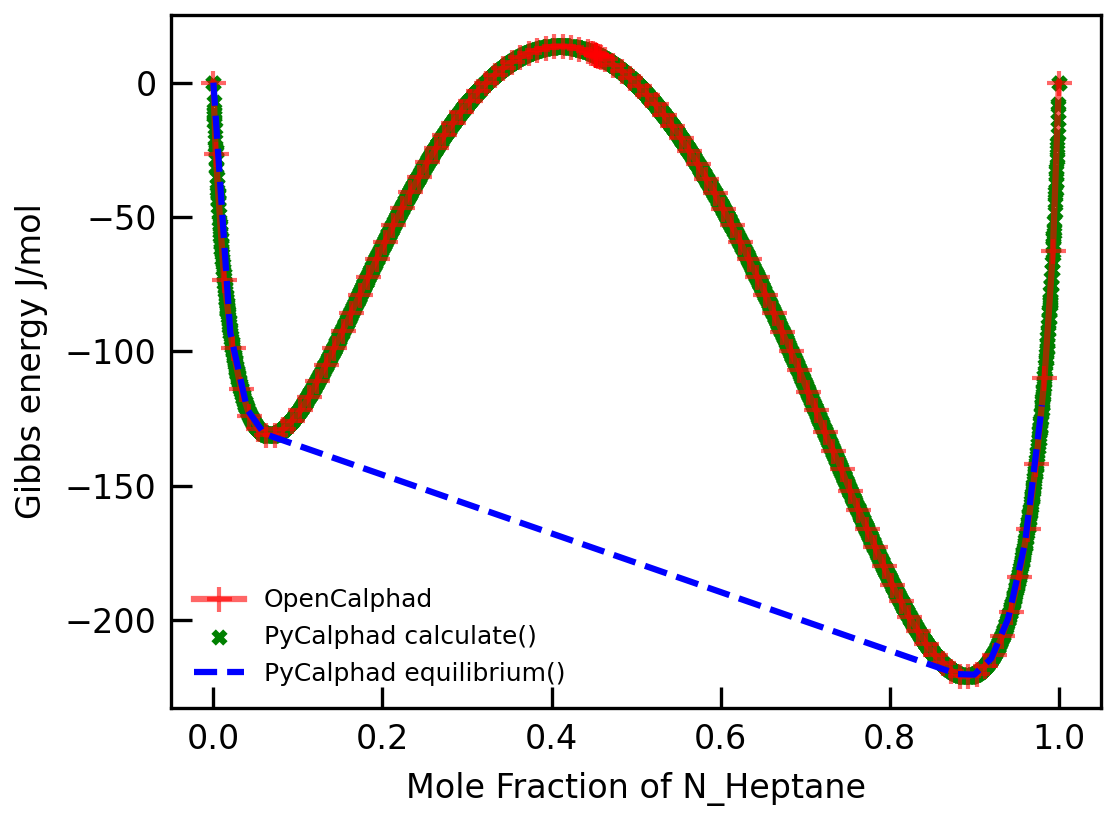

In [20]:

plt.style.use('MQMQA_plot.mplstyle')
fig = plt.figure()
fig.gca().set_xlabel('Mole Fraction of N_Heptane')
fig.gca().set_ylabel('Gibbs energy J/mol')

fig.gca().plot(x_op_fig3, y_op_fig3, '+-', markersize=6, color='red', alpha=0.6, label='OpenCalphad')
fig.gca().scatter(calc_res_3.X.sel(component='H'), calc_res_3.GM, marker='x', s=8, color='green',label='PyCalphad calculate()')
fig.gca().plot(eq_3.X_H.squeeze(), eq_3.GM.squeeze(), '--', markerfacecolor='none', color='blue', markersize=8, label='PyCalphad equilibrium()')

plt.legend(fontsize=6)
#plt.savefig('Fig3Py.png', dpi=300)

In [21]:
eq_3

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_H: 51, vertex: 3, component: 2,
                internal_dof: 2)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 320.0
  * X_H        (X_H) float64 1e-10 0.02 0.04 0.06 0.08 ... 0.94 0.96 0.98 1.0
  * vertex     (vertex) int64 0 1 2
  * component  (component) <U1 'C' 'H'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_H, vertex) float64 1.0 nan nan 1.0 ... nan nan nan
    GM         (N, P, T, X_H) float64 -5.529e-06 -93.24 -121.7 ... -120.1 nan
    MU         (N, P, T, X_H, component) float64 -2.661e-07 -5.262e+04 ... nan
    X          (N, P, T, X_H, vertex, component) float64 1.0 1e-10 ... nan nan
    Y          (N, P, T, X_H, vertex, internal_dof) float64 1.0 1e-10 ... nan
    Phase      (N, P, T, X_H, vertex) <U6 'LIQUID' '' '' 'LIQUID' ... '' '' ''
Attributes:
    engine:   pycalphad 0.1.dev1906+g2eaab13.d20240215
    created:  2024-02-15T15:54:04.767541

#### Entropy

In [22]:
dbf=Database('uniquac_test_fig3.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comps=['C', 'H', 'VA']
phases=['LIQUID']
calc_res_sm_3=calculate(dbf, comps, phases, P=101325, T=320, model=models, output='SM')

conds={v.N: 1, v.P: 101325, v.T: 320,  v.X('H'): (0, 1.02, 0.02)}
eq_sm_3=equilibrium(dbf, comps, phases, conds, model=models, output='SM')

/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/utils.py:54: RuntimeWarning: invalid value encountered in divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]
/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/lower_convex_hull.py:145: RuntimeWarning: invalid value encountered in scalar divide
  result_array_GM_values[it.multi_index] = new_energy / molesum


In [23]:
oc_x_b_2=[0.452736, 0.452746, 0.452756, 0.454756, 0.456756, 0.458756, 0.462736, 0.472736, 0.482736, 0.492736, 0.502736, 0.512736, 0.522736, 0.532736, 0.542736, 0.552736, 0.562736, 0.572736, 0.582736, 0.592736, 0.602736, 0.612736, 0.622736, 0.632736, 0.642736, 0.652736, 0.662736, 0.672736, 0.682736, 0.692736, 0.702736, 0.712736, 0.722736, 0.732736, 0.742736, 0.752736, 0.762736, 0.772736, 0.782736, 0.792736, 0.802736, 0.812736, 0.822736, 0.832736, 0.842736, 0.852736, 0.862736, 0.872736, 0.882736, 0.892736, 0.902736, 0.912736, 0.922736, 0.932736, 0.942736, 0.952736, 0.962736, 0.972736, 0.982736, 0.992736, 1.000000, 0.452736, 0.452726, 0.452716, 0.450716, 0.448716, 0.446716, 0.442736, 0.432736, 0.422736, 0.412736, 0.402736, 0.392736, 0.382736, 0.372736, 0.362736, 0.352736, 0.342736, 0.332736, 0.322736, 0.312736, 0.302736, 0.292736, 0.282736, 0.272736, 0.262736, 0.252736, 0.242736, 0.232736, 0.222736, 0.212736, 0.202736, 0.192736, 0.182736, 0.172736, 0.162736, 0.152736, 0.142736, 0.132736, 0.122736, 0.112736, 0.102736, 0.092736, 0.082736, 0.072736, 0.062736, 0.052736, 0.042736, 0.032736, 0.022736, 0.012736, 0.002736, 0.000000]
oc_sm_liq2=[4.048812, 4.048855, 4.048898, 4.057411, 4.065858, 4.074240, 4.090724, 4.130961, 4.169461, 4.206162, 4.240994, 4.273888, 4.304769, 4.333558, 4.360175, 4.384535, 4.406548, 4.426122, 4.443159, 4.457558, 4.469213, 4.478014, 4.483844, 4.486583, 4.486103, 4.482273, 4.474953, 4.463997, 4.449252, 4.430559, 4.407748, 4.380640, 4.349049, 4.312776, 4.271611, 4.225333, 4.173706, 4.116478, 4.053381, 3.984129, 3.908414, 3.825905, 3.736243, 3.639039, 3.533868, 3.420262, 3.297706, 3.165623, 3.023366, 2.870198, 2.705270, 2.527588, 2.335964, 2.128943, 1.904689, 1.660784, 1.393855, 1.098785, 0.766676, 0.377173, 0.000000, 4.048812, 4.048770, 4.048727, 4.040148, 4.031505, 4.022798, 4.005284, 3.960193, 3.913592, 3.865529, 3.816049, 3.765193, 3.713000, 3.659506, 3.604741, 3.548734, 3.491508, 3.433083, 3.373474, 3.312692, 3.250743, 3.187627, 3.123338, 3.057865, 2.991189, 2.923284, 2.854113, 2.783632, 2.711786, 2.638505, 2.563707, 2.487294, 2.409147, 2.329128, 2.247070, 2.162776, 2.076013, 1.986501, 1.893905, 1.797820, 1.697751, 1.593089, 1.483070, 1.366719, 1.242762, 1.109479, 0.964442, 0.804005, 0.622127, 0.406903, 0.121758, 0.000000]
oc_x_b=[1.00E-01, 2.00E-01, 3.00E-01, 4.00E-01,  5.00E-01, 6.00E-01, 7.00E-01, 8.00E-01, 9.00E-01]
oc_s=[1.3150, 1.5350, 1.7540, 1.9730, 2.1920, 2.4120, 2.6310, 2.8500, 2.7520]

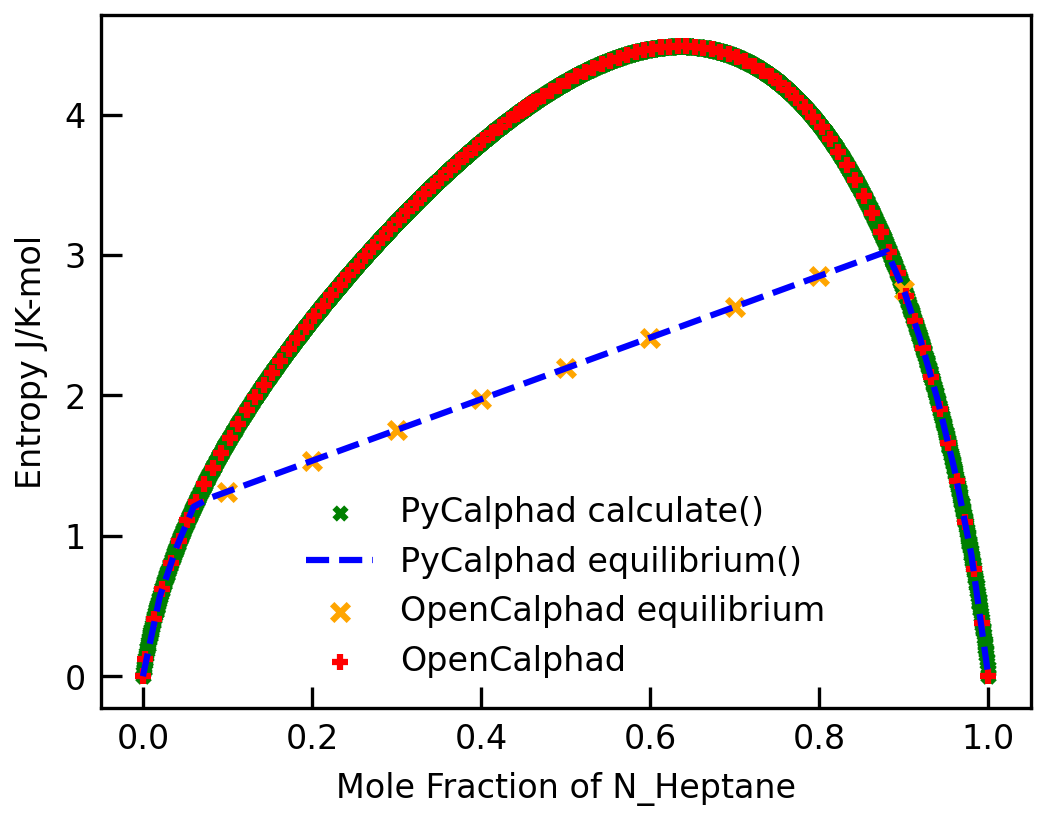

In [24]:
plt.style.use('MQMQA_plot.mplstyle')
fig = plt.figure()
fig.gca().set_xlabel('Mole Fraction of N_Heptane')
fig.gca().set_ylabel('Entropy J/K-mol')

fig.gca().scatter(calc_res_sm_3.X.sel(component='H'), calc_res_sm_3.SM, marker='x', s=8, color='green',label='PyCalphad calculate()')
fig.gca().plot(eq_sm_3.X_H.squeeze(), eq_sm_3.SM.squeeze(), '--', markerfacecolor='none', color='blue', markersize=8, label='PyCalphad equilibrium()')
fig.gca().scatter(oc_x_b, oc_s, marker='x', s=16, color='orange', label='OpenCalphad equilibrium')
fig.gca().scatter(oc_x_b_2, oc_sm_liq2, marker='+', s=16, color='red', label='OpenCalphad')
plt.legend()
#plt.savefig('AN-binary-Entropy.png', dpi=300)

#### Phase diagram

In [25]:
oc_t_pd=[400.000000, 400.000500, 400.010500, 400.030500, 400.070500, 400.870500, 402.470500, 405.670500, 410.670500, 415.670500, 420.670500, 425.670500, 430.670500, 435.670500, 440.670500, 445.670500, 450.670500, 455.670500, 455.667800, 455.667800, 455.667900, 455.669900, 455.673700, 455.681400, 455.835300, 456.142000, 456.751100, 457.952100, 460.231300, 462.421100, 464.519900, 466.525600, 468.436100, 470.248900, 471.961200, 473.570100, 475.072300, 476.464100, 477.741500, 478.900200, 479.935500, 480.842300, 400.000000, 399.999500, 399.989500, 399.969500, 399.929500, 399.129500, 397.529500, 394.329500, 389.329500, 384.329500, 379.329500, 374.329500, 369.329500, 364.329500, 359.329500, 354.329500, 349.329500, 344.329500, 339.329500, 334.329500, 329.329500, 324.329500, 319.329500, 314.329500, 309.329500, 304.329500, 299.329500, 294.329500, 289.329500, 284.329500, 279.329500, 274.329500, 270.000000]
oc_liq1_pd=[0.725681, 0.725679, 0.725657, 0.725607, 0.725506, 0.723484, 0.719406, 0.711118, 0.697797, 0.684000, 0.669689, 0.654824, 0.639352, 0.623204, 0.606298, 0.588518, 0.569712, 0.549663, 0.549663, 0.549663, 0.549662, 0.549654, 0.549638, 0.549606, 0.548966, 0.547686, 0.545126, 0.540006, 0.530006, 0.520006, 0.510006, 0.500006, 0.490006, 0.480006, 0.470006, 0.460006, 0.450006, 0.440006, 0.430006, 0.420006, 0.410006, 0.400006, 0.725681, 0.725682, 0.725705, 0.725754, 0.725856, 0.727865, 0.731853, 0.739701, 0.751639, 0.763195, 0.774381, 0.785212, 0.795698, 0.805847, 0.815670, 0.825172, 0.834362, 0.843244, 0.851824, 0.860108, 0.868101, 0.875806, 0.883228, 0.890371, 0.897239, 0.903836, 0.910165, 0.916230, 0.922036, 0.927584, 0.932881, 0.937928, 0.942101]
oc_liq2_pd=[0.115107, 0.115107, 0.115116, 0.115135, 0.115173, 0.115937, 0.117484, 0.120662, 0.125868, 0.131396, 0.137284, 0.143578, 0.150333, 0.157620, 0.165527, 0.174171, 0.183710, 0.194363, 0.194360, 0.194359, 0.194359, 0.194366, 0.194376, 0.194397, 0.194747, 0.195446, 0.196852, 0.199690, 0.205339, 0.211135, 0.217086, 0.223196, 0.229474, 0.235928, 0.242565, 0.249394, 0.256424, 0.263667, 0.271132, 0.278831, 0.286779, 0.294746, 0.115107, 0.115106, 0.115098, 0.115079, 0.115041, 0.114285, 0.112793, 0.109886, 0.105533, 0.101396, 0.097456, 0.093700, 0.090114, 0.086687, 0.083408, 0.080268, 0.077258, 0.074371, 0.071601, 0.068940, 0.066383, 0.063924, 0.061560, 0.059284, 0.057094, 0.054985, 0.052953, 0.050995, 0.049109, 0.047291, 0.045538, 0.043848, 0.042434]

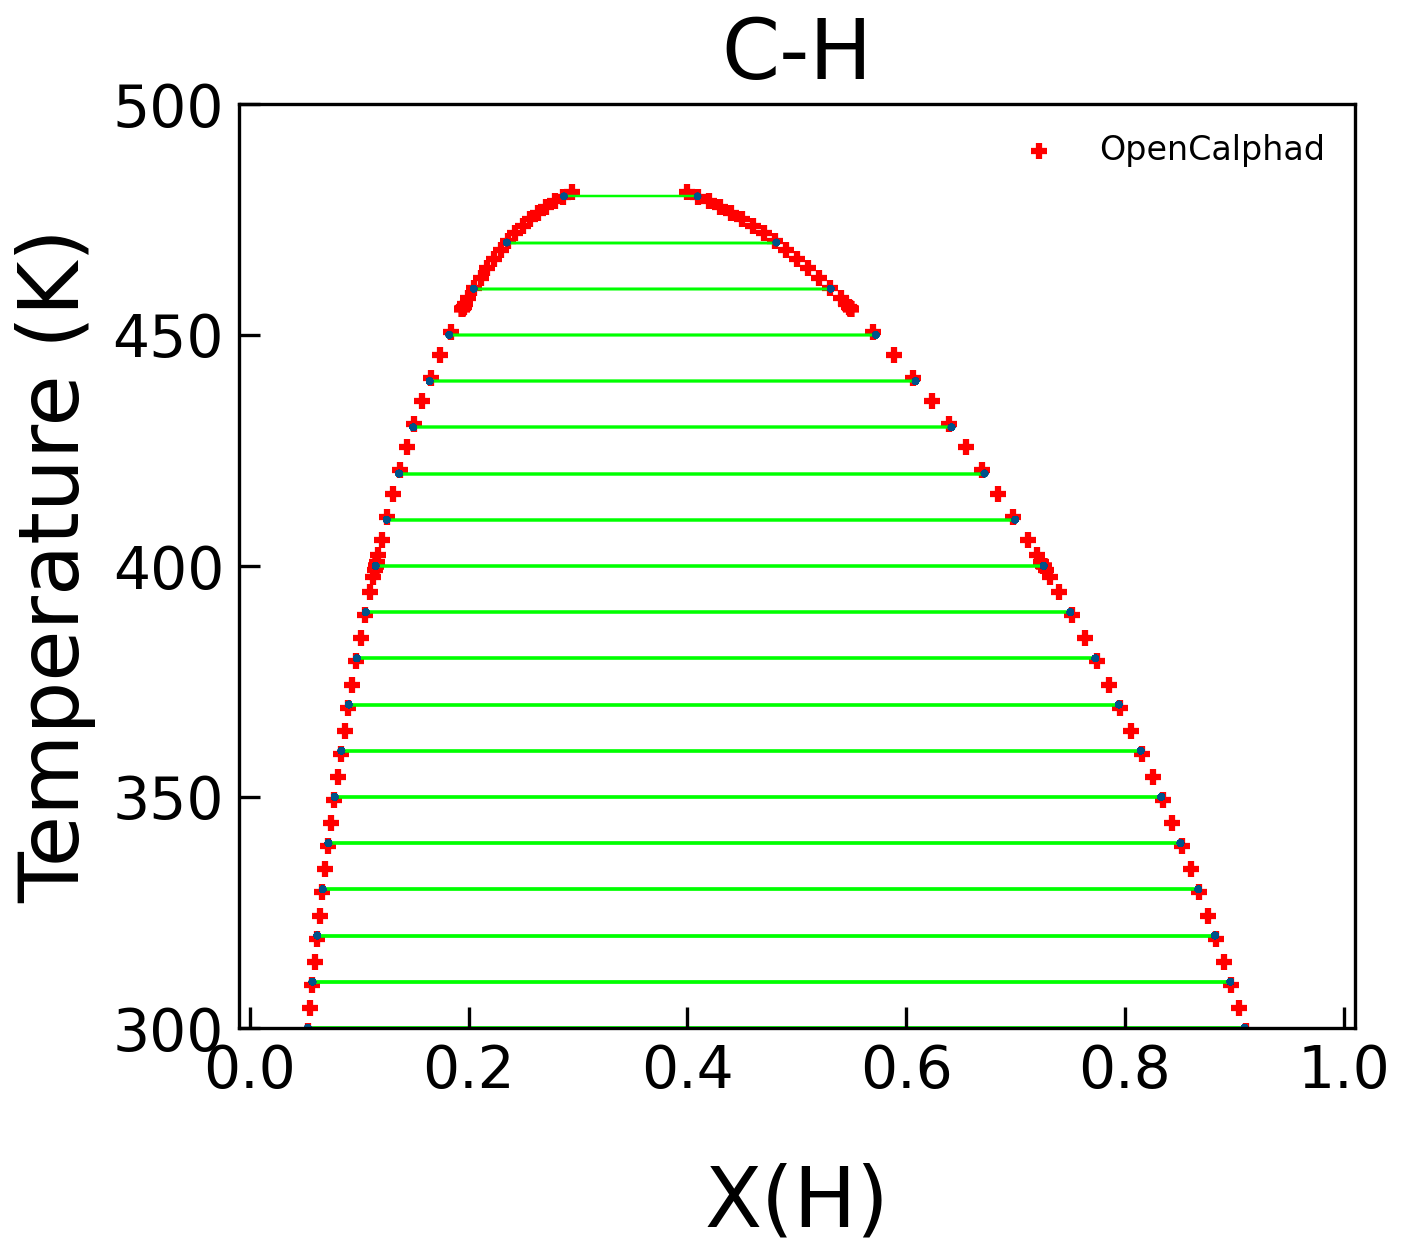

In [26]:
import matplotlib.pyplot as plt
from pycalphad import Database, binplot, equilibrium
from pycalphad.plot.eqplot import eqplot
import pycalphad.variables as v

# Load database and choose the phases that will be considered
dbf=Database('uniquac_test_fig3.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comps=['C', 'H', 'VA']
phases=['LIQUID']
fig = plt.figure(figsize=(6,4))
axes = fig.gca()
# Create a matplotlib Figure object and get the active Axes
plt.scatter(oc_liq1_pd, oc_t_pd,  marker='+', s=16, color='red', label='OpenCalphad')
plt.scatter(oc_liq2_pd, oc_t_pd,  marker='+', s=16, color='red')
# Compute the phase diagram and plot it on the existing axes using the `plot_kwargs={'ax': axes}` keyword argument
eq=equilibrium(dbf, comps , phases, {v.X('H'):(0,1,0.02), v.T: (300, 500, 10), v.P:101325, v.N: 1}, model=models)
eqplot(eq, ax=axes, x=v.X('H'), y=v.T)
plt.ylim([300, 500])
plt.xlim([-0.01, 1.01])
plt.grid(False)
plt.legend()
#plt.show()
#plt.savefig('UNIQUAC-binary-phasediagram.png', bbox_inches = 'tight', dpi=300)

### Ternary case

In [27]:
dbf=Database('uniquac_test_ternary.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comps=['C', 'H', 'N']
phases=['LIQUID']

conds = {v.N: 1, v.P: 101325, v.T: 320, v.X('H'): 0.5, v.X('N'): 0.1}
eq_t = equilibrium(dbf, comps, phases, conds, model=models, verbose=False)
eq_t

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_H: 1, X_N: 1, vertex: 4, component: 3,
                internal_dof: 3)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 320.0
  * X_H        (X_H) float64 0.5
  * X_N        (X_N) float64 0.1
  * vertex     (vertex) int64 0 1 2 3
  * component  (component) <U1 'C' 'H' 'N'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_H, X_N, vertex) float64 0.3302 0.6698 nan nan
    GM         (N, P, T, X_H, X_N) float64 -944.8
    MU         (N, P, T, X_H, X_N, component) float64 -287.0 -549.2 -5.553e+03
    X          (N, P, T, X_H, X_N, vertex, component) float64 0.832 ... nan
    Y          (N, P, T, X_H, X_N, vertex, internal_dof) float64 0.832 ... nan
    Phase      (N, P, T, X_H, X_N, vertex) <U6 'LIQUID' 'LIQUID' '' ''
Attributes:
    engine:   pycalphad 0.1.dev1906+g2eaab13.d20240215
    created:  2024-02-15T15:54:17.114139

In [28]:
oc_xb=[0.09462339, 0.09462378, 0.09463182, 0.09464844, 0.09468075, 0.09533654, 0.09667267, 0.09944958, 0.10410370, 0.10638880, 0.11172630, 0.11424890, 0.11424530, 0.11424500, 0.11424500, 0.11424750, 0.11425240, 0.11426170, 0.11443980, 0.11479330, 0.11550450, 0.11694260, 0.11981250, 0.12276750, 0.12581110, 0.12894740, 0.13218070, 0.13551500, 0.13895580, 0.14250840, 0.14617830, 0.14997150, 0.15389390, 0.15795280, 0.16215590, 0.16651060, 0.17102630, 0.19278780, 0.19278780, 0.09462339, 0.09462302, 0.09461545, 0.09459912, 0.09456652, 0.09392028, 0.09265205, 0.09020438, 0.08659671, 0.08489410, 0.08162887, 0.07856166, 0.07567012, 0.07293745, 0.07034841, 0.06789074, 0.06555353, 0.06532616, 0.06509975, 0.06487439, 0.06465011, 0.06442690, 0.06420475, 0.06398365, 0.06376359, 0.06354457, 0.06332714, 0.06311015, 0.06289417, 0.06267919, 0.06246520, 0.06225220, 0.06204018, 0.06187168, 0.41723680, 0.41723510, 0.41713450, 0.41703400, 0.69980640, 0.69980470, 0.69977040, 0.69969680, 0.69955030, 0.69661540, 0.69070320, 0.67869080, 0.65937670, 0.65024830, 0.62977510, 0.62048890, 0.62048880, 0.62048860, 0.62048820, 0.62048020, 0.62046420, 0.62043220, 0.61979220, 0.61851220, 0.61595220, 0.61083220, 0.60083220, 0.59083220, 0.58083220, 0.57083220, 0.56083220, 0.55083220, 0.54083220, 0.53083220, 0.52083220, 0.51083220, 0.50083220, 0.49083220, 0.48083220, 0.47083220, 0.46083220, 0.41729390, 0.41729390, 0.69980640, 0.69980810, 0.69984310, 0.69991620, 0.70006240, 0.70298040, 0.70877440, 0.72020490, 0.73767520, 0.74619140, 0.76303430, 0.77951090, 0.79565470, 0.81149490, 0.82705660, 0.84236260, 0.85743070, 0.85892530, 0.86041760, 0.86190770, 0.86339570, 0.86488150, 0.86636520, 0.86784680, 0.86932630, 0.87080370, 0.87227850, 0.87375180, 0.87522310, 0.87669240, 0.87815960, 0.87962480, 0.88108810, 0.88224930, 0.41723360, 0.41723260, 0.41713260, 0.41703260]
oc_xc=[0.07341576, 0.07341651, 0.07343151, 0.07346106, 0.07351990, 0.07470222, 0.07708435, 0.08192158, 0.08969517, 0.09336682, 0.10159310, 0.10531930, 0.10531610, 0.10531600, 0.10531610, 0.10531960, 0.10532620, 0.10533930, 0.10559660, 0.10610980, 0.10713620, 0.10918800, 0.11319110, 0.11718840, 0.12117890, 0.12516150, 0.12913500, 0.13309790, 0.13704910, 0.14098680, 0.14490950, 0.14881510, 0.15270110, 0.15656530, 0.16040500, 0.16421700, 0.16799820, 0.18399630, 0.18399630, 0.07341576, 0.07341503, 0.07340032, 0.07337081, 0.07331184, 0.07213624, 0.06980189, 0.06519673, 0.05815833, 0.05472772, 0.04794318, 0.04130850, 0.03480975, 0.02843565, 0.02217612, 0.01602259, 0.00996725, 0.00936685, 0.00876736, 0.00816876, 0.00757105, 0.00697423, 0.00637830, 0.00578323, 0.00518904, 0.00459571, 0.00400324, 0.00341162, 0.00282084, 0.00223090, 0.00164180, 0.00105353, 0.00046608, 0.00000001, 0.22090160, 0.22090410, 0.22109010, 0.22127600, 0.11310310, 0.11310410, 0.11312410, 0.11316410, 0.11324410, 0.11484410, 0.11804410, 0.12444410, 0.13444410, 0.13904200, 0.14904200, 0.15343090, 0.15342890, 0.15342900, 0.15342920, 0.15343300, 0.15344050, 0.15345550, 0.15375430, 0.15435090, 0.15553860, 0.15789220, 0.16240350, 0.16679940, 0.17107670, 0.17523230, 0.17926270, 0.18316460, 0.18693420, 0.19056780, 0.19406120, 0.19741040, 0.20061090, 0.20365790, 0.20654670, 0.20927210, 0.21182870, 0.22084820, 0.22084820, 0.11310310, 0.11310210, 0.11308210, 0.11304210, 0.11296210, 0.11136210, 0.10816210, 0.10176210, 0.09176214, 0.08679438, 0.07679438, 0.06679438, 0.05679438, 0.04679438, 0.03679438, 0.02679438, 0.01679438, 0.01579438, 0.01479438, 0.01379438, 0.01279438, 0.01179438, 0.01079438, 0.00979439, 0.00879439, 0.00779439, 0.00679439, 0.00579439, 0.00479439, 0.00379439, 0.00279439, 0.00179439, 0.00079439, 0.00000001, 0.22090160, 0.22090410, 0.22109010, 0.22127600]

/Users/thea/Desktop/DOE NEUP 22/pycalphad-dev/pycalphad/pycalphad/core/lower_convex_hull.py:145: RuntimeWarning: invalid value encountered in scalar divide
  result_array_GM_values[it.multi_index] = new_energy / molesum


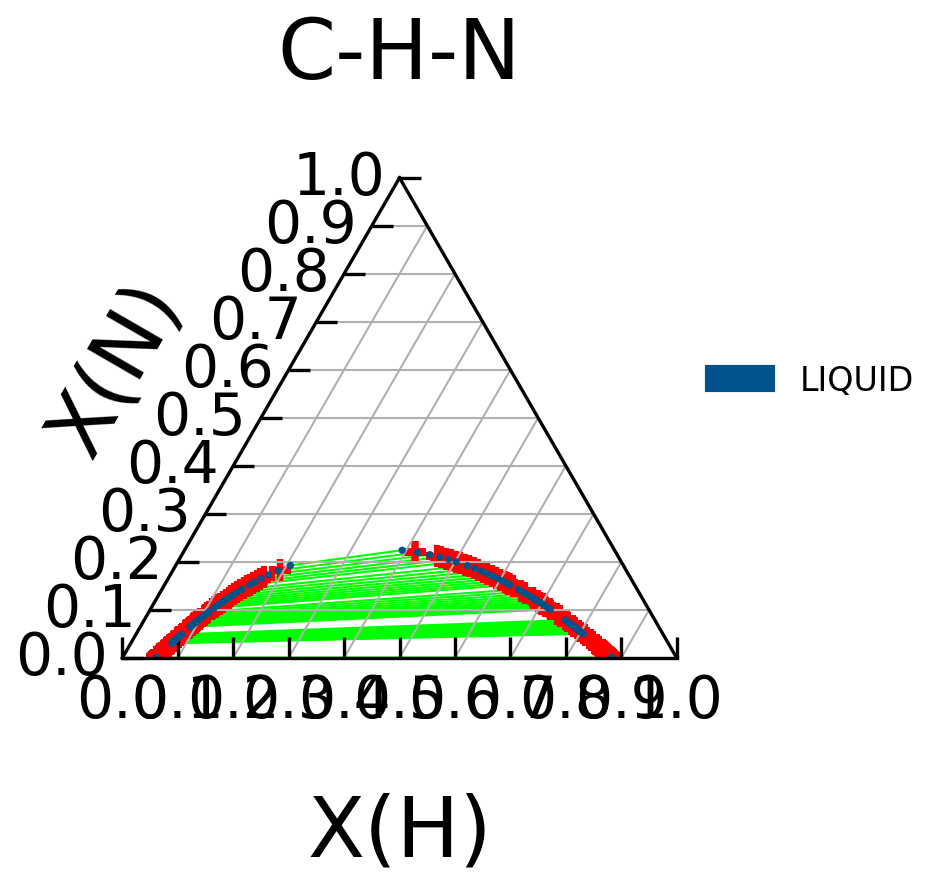

In [29]:
from pycalphad.plot import triangular
from pycalphad import ternplot
dbf=Database('uniquac_test_ternary.xml')
##ACETONITRILE: C2H3N1
##N_HEPTANE: C7H16
models = {'LIQUID': ModelUNIQUAC}
comps=['C', 'H', 'N']
phases=['LIQUID']
# Create a matplotlib Figure object and get the active Axes
#fig = plt.figure()
#ax = fig.add_subplot(projection='triangular')
# Compute the phase diagram and plot it on the existing axes using the `plot_kwargs={'ax': axes}` keyword argument
#eq=equilibrium(dbf, comps , phases, {v.X('H'):(0,1,0.1), v.X('N'):(0,1,0.1), v.T: 320, v.P:101325, v.N: 1}, model=models)
#eqplot(eq, ax=axes, x=v.X('H'), y=v.X('N'))
conds={v.X('H'):(0,1,0.05), v.X('N'):(0,1,0.05), v.T: 320, v.P:101325, v.N: 1}
ternplot(dbf, comps, phases, conds, x=v.X('H'), y=v.X('N'), eq_kwargs={'model':models})
plt.scatter(oc_xb, oc_xc, marker='+', s=26, color='red', label='OpenCalphad')
#plt.savefig('UNIQUAC-ternary-phasediagram.png', bbox_inches = 'tight', dpi=300)